In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.cm as cm
import pmdarima as pm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson

# 2 Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias 

In [2]:
#agbarometer

df_agbarometer = pd.read_csv('../data/clean_data/agbarometer_cleaned.csv')
print(df_agbarometer.head(10))

     Bimestre  CondicIones presentes  Expectativas futuras  Ag Barometer
0  2018-11-01                     43                   130            95
1  2019-01-01                     59                   137           106
2  2019-03-01                     69                   126           103
3  2019-05-01                     82                   141           117
4  2019-07-01                    105                   158           137
5  2019-09-01                     64                    80            74
6  2019-11-01                     64                    64            64
7  2020-01-01                     46                    56            52
8  2020-04-01                     50                    54            53
9  2020-07-01                     52                    45            48


In [3]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Bimestre               41 non-null     object
 1   CondicIones presentes  41 non-null     int64 
 2   Expectativas futuras   41 non-null     int64 
 3   Ag Barometer           41 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ KB


In [4]:
print(df_agbarometer['Bimestre'].head())

0    2018-11-01
1    2019-01-01
2    2019-03-01
3    2019-05-01
4    2019-07-01
Name: Bimestre, dtype: object


In [5]:
df_agbarometer['Bimestre'] = pd.to_datetime(df_agbarometer['Bimestre'], format='%Y-%m-%d')
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bimestre               41 non-null     datetime64[ns]
 1   CondicIones presentes  41 non-null     int64         
 2   Expectativas futuras   41 non-null     int64         
 3   Ag Barometer           41 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 KB


In [6]:
df_agbarometer.set_index('Bimestre', inplace=True)
df_agbarometer.head()

,CondicIones presentes,Expectativas futuras,Ag Barometer
Bimestre,,,
2018-11-01,43,130,95
2019-01-01,59,137,106
2019-03-01,69,126,103
2019-05-01,82,141,117
2019-07-01,105,158,137


In [7]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2018-11-01 to 2025-09-01
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   CondicIones presentes  41 non-null     int64
 1   Expectativas futuras   41 non-null     int64
 2   Ag Barometer           41 non-null     int64
dtypes: int64(3)
memory usage: 1.3 KB


In [8]:
data1 = df_agbarometer['Ag Barometer']

In [9]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 29 y 62 dias

df_time_diffs = data1.index.to_series().diff()
print(df_time_diffs.value_counts())

Bimestre
61 days    25
62 days     7
59 days     5
91 days     2
60 days     1
Name: count, dtype: int64


In [10]:
# Vemos que hay dos intervalos de 91 dias

In [11]:
# Filtrar los bimestres con diferencia de 91 días
filtered_91 = df_time_diffs[df_time_diffs == pd.Timedelta(days=91)]
print(filtered_91)

Bimestre
2020-04-01   91 days
2020-07-01   91 days
Name: Bimestre, dtype: timedelta64[ns]


In [12]:
# Buscamos los indices de esos bimestres
indices_91 = filtered_91.index

for idx in indices_91:
    if idx not in df_agbarometer.index:
        print(f"\n{idx} no se encuentra en df_agbarometer")
        continue
    pos = df_agbarometer.index.get_loc(idx)
    start = max(0, pos - 2)
    end = min(len(df_agbarometer) - 2, pos + 2)
    print(f"\n--- Contexto alrededor de {idx.date()} (posición {pos}) ---")
    print(df_agbarometer.iloc[start:end+2])


--- Contexto alrededor de 2020-04-01 (posición 8) ---
            CondicIones presentes  Expectativas futuras  Ag Barometer
Bimestre                                                             
2019-11-01                     64                    64            64
2020-01-01                     46                    56            52
2020-04-01                     50                    54            53
2020-07-01                     52                    45            48
2020-09-01                     74                    65            69
2020-11-01                     76                    80            78

--- Contexto alrededor de 2020-07-01 (posición 9) ---
            CondicIones presentes  Expectativas futuras  Ag Barometer
Bimestre                                                             
2020-01-01                     46                    56            52
2020-04-01                     50                    54            53
2020-07-01                     52                 

Vemos que lo que ha pasado es un desfazaje en los meses de pandemia. Deberiamos tener 2020-03, 2020-05 y 2020-07.
En su lugar, tenemos solo 2020-04. Se decide interpolar los valores faltantes y eliminar el 2020-04 para evitar ruido en periodicidad

In [13]:
# Valores para interpolar
valor_2020_01_01 = data1.loc['2020-01-01'] 
valor_2020_04_01 = data1.loc['2020-04-01'] 
valor_2020_07_01 = data1.loc['2020-07-01'] 

# Calcular los promedios
valor_promedio_2020_03_01 = (valor_2020_01_01 + valor_2020_04_01) / 2 

valor_promedio_2020_05_01 = (valor_2020_04_01 + valor_2020_07_01) / 2 

# Agregar los datos
fecha_a_insertar_1 = pd.to_datetime('2020-03-01')
fecha_a_insertar_2 = pd.to_datetime('2020-05-01')

data1.loc[fecha_a_insertar_1] = valor_promedio_2020_03_01
data1.loc[fecha_a_insertar_2] = valor_promedio_2020_05_01

# Eliminar dato de abril
fecha_a_eliminar = pd.to_datetime('2020-04-01')
data1 = data1.drop(fecha_a_eliminar)

# Ordenar la Serie por índice 
data1 = data1.sort_index()
print(data1.loc['2019-11-01':'2020-11-01'])

Bimestre
2019-11-01    64.0
2020-01-01    52.0
2020-03-01    52.5
2020-05-01    50.5
2020-07-01    48.0
2020-09-01    69.0
2020-11-01    78.0
Name: Ag Barometer, dtype: float64


In [14]:
# Asignamos frecuencia bimestral
data1 = data1.asfreq('2MS')

# Corroboramos que la frecuencia sea bimestral
print(data1.index)

DatetimeIndex(['2018-11-01', '2019-01-01', '2019-03-01', '2019-05-01',
               '2019-07-01', '2019-09-01', '2019-11-01', '2020-01-01',
               '2020-03-01', '2020-05-01', '2020-07-01', '2020-09-01',
               '2020-11-01', '2021-01-01', '2021-03-01', '2021-05-01',
               '2021-07-01', '2021-09-01', '2021-11-01', '2022-01-01',
               '2022-03-01', '2022-05-01', '2022-07-01', '2022-09-01',
               '2022-11-01', '2023-01-01', '2023-03-01', '2023-05-01',
               '2023-07-01', '2023-09-01', '2023-11-01', '2024-01-01',
               '2024-03-01', '2024-05-01', '2024-07-01', '2024-09-01',
               '2024-11-01', '2025-01-01', '2025-03-01', '2025-05-01',
               '2025-07-01', '2025-09-01'],
              dtype='datetime64[ns]', name='Bimestre', freq='2MS')


In [15]:
# Dividimos en train y test
# Seleccionamos el primer 90% para train
train1 = data1.iloc[:round(len(data1)*.9)]
# Seleccionamos el 10% restante para test
test1 = data1.iloc[round(len(data1)*.9):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train1, test1)

Bimestre
2018-11-01     95.0
2019-01-01    106.0
2019-03-01    103.0
2019-05-01    117.0
2019-07-01    137.0
2019-09-01     74.0
2019-11-01     64.0
2020-01-01     52.0
2020-03-01     52.5
2020-05-01     50.5
2020-07-01     48.0
2020-09-01     69.0
2020-11-01     78.0
2021-01-01     79.0
2021-03-01     90.0
2021-05-01     79.0
2021-07-01     69.0
2021-09-01     79.0
2021-11-01     79.0
2022-01-01     90.0
2022-03-01     90.0
2022-05-01     98.0
2022-07-01     76.0
2022-09-01     83.0
2022-11-01     67.0
2023-01-01     68.0
2023-03-01     69.0
2023-05-01     84.0
2023-07-01     89.0
2023-09-01    100.0
2023-11-01    117.0
2024-01-01    119.0
2024-03-01    129.0
2024-05-01    139.0
2024-07-01    139.0
2024-09-01    132.0
2024-11-01    149.0
2025-01-01    117.0
Freq: 2MS, Name: Ag Barometer, dtype: float64 Bimestre
2025-03-01    137.0
2025-05-01    130.0
2025-07-01    127.0
2025-09-01    124.0
Freq: 2MS, Name: Ag Barometer, dtype: float64


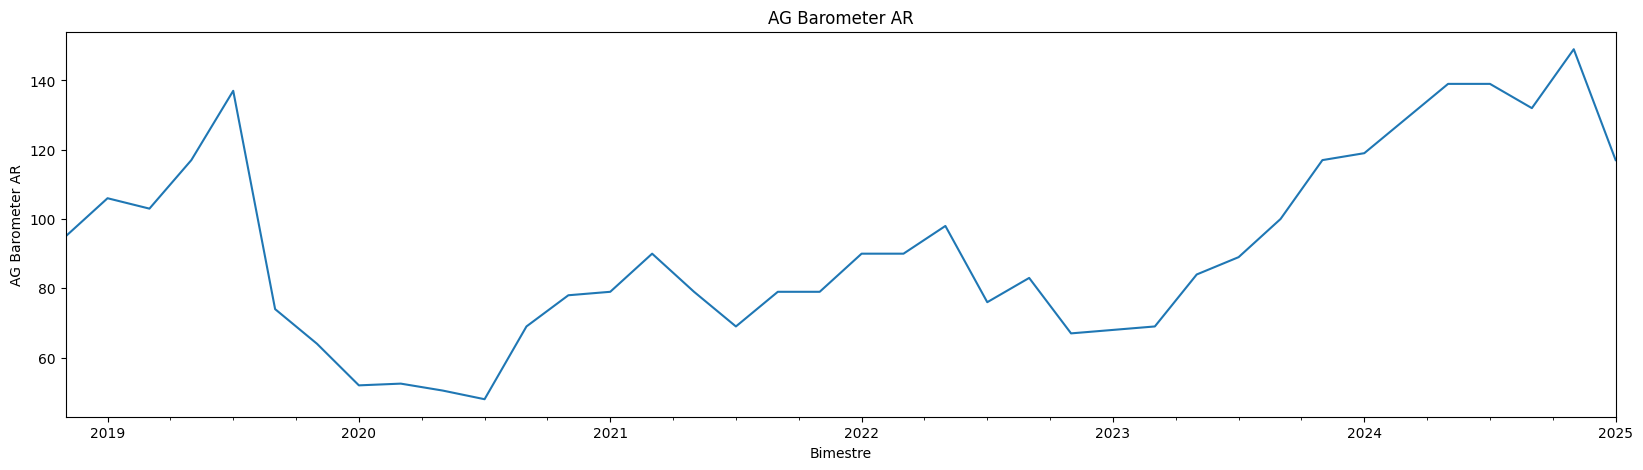

In [16]:
train1.plot(figsize=(20,5), title = "AG Barometer AR", ylabel = "AG Barometer AR", xlabel = "Bimestre")
plt.show()

In [17]:
#ageconomy

df_ageconomy = pd.read_csv('../data/clean_data/AgEconomyBarometer_cleaned.csv')
print(df_ageconomy.head())

      Month  Year  Purdue/CME Ag Economy Barometer  \
0   October  2015                              116   
1  November  2015                               97   
2  December  2015                              107   
3   January  2016                               98   
4  February  2016                               96   

   Index of Current Conditions  Index of Future Expectations  \
0                          118                           116   
1                           98                            97   
2                          125                            98   
3                           99                            98   
4                           82                           102   

   Farm Capital Investment Index  
0                             67  
1                             51  
2                             75  
3                             52  
4                             56  


In [18]:
df_ageconomy['Date'] = df_ageconomy['Year'].astype(str) + '-' + df_ageconomy['Month'].astype(str).str.zfill(2) + '-01'
df_ageconomy['Date'] = pd.to_datetime(df_ageconomy['Date'])

In [19]:
df_ageconomy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Month                            121 non-null    object        
 1   Year                             121 non-null    int64         
 2   Purdue/CME Ag Economy Barometer  121 non-null    int64         
 3   Index of Current Conditions      121 non-null    int64         
 4   Index of Future Expectations     121 non-null    int64         
 5   Farm Capital Investment Index    121 non-null    int64         
 6   Date                             121 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 6.7+ KB


In [20]:
df_ageconomy.set_index('Date', inplace=True)
df_ageconomy.head()

,Month,Year,Purdue/CME Ag Economy Barometer,Index of Current Conditions,Index of Future Expectations,Farm Capital Investment Index
Date,,,,,,
2015-10-01,October,2015,116,118,116,67
2015-11-01,November,2015,97,98,97,51
2015-12-01,December,2015,107,125,98,75
2016-01-01,January,2016,98,99,98,52
2016-02-01,February,2016,96,82,102,56


In [21]:
data2 = df_ageconomy['Purdue/CME Ag Economy Barometer']

In [22]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 28 y 31 dias

df_time_diffs = data2.index.to_series().diff()
print(df_time_diffs.value_counts())

Date
31 days    70
30 days    40
28 days     7
29 days     3
Name: count, dtype: int64


In [23]:
# Asignamos frecuencia mensual
data2 = data2.asfreq('MS')

# Corroboramos que la frecuencia sea mensual
print(data2.index)

DatetimeIndex(['2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01',
               ...
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01'],
              dtype='datetime64[ns]', name='Date', length=121, freq='MS')


In [24]:
# Dividimos en train y test
# Seleccionamos el primer 80% para train
train2 = data2.iloc[:round(len(data2)*.8)]
# Seleccionamos el 20% restante para test
test2 = data2.iloc[round(len(data2)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train2, test2)

Date
2015-10-01    116
2015-11-01     97
2015-12-01    107
2016-01-01     98
2016-02-01     96
             ... 
2023-06-01    121
2023-07-01    123
2023-08-01    115
2023-09-01    106
2023-10-01    110
Freq: MS, Name: Purdue/CME Ag Economy Barometer, Length: 97, dtype: int64 Date
2023-11-01    115
2023-12-01    114
2024-01-01    106
2024-02-01    111
2024-03-01    114
2024-04-01     99
2024-05-01    108
2024-06-01    105
2024-07-01    113
2024-08-01    100
2024-09-01     88
2024-10-01    115
2024-11-01    145
2024-12-01    136
2025-01-01    141
2025-02-01    152
2025-03-01    140
2025-04-01    148
2025-05-01    158
2025-06-01    146
2025-07-01    135
2025-08-01    125
2025-09-01    126
2025-10-01    129
Freq: MS, Name: Purdue/CME Ag Economy Barometer, dtype: int64


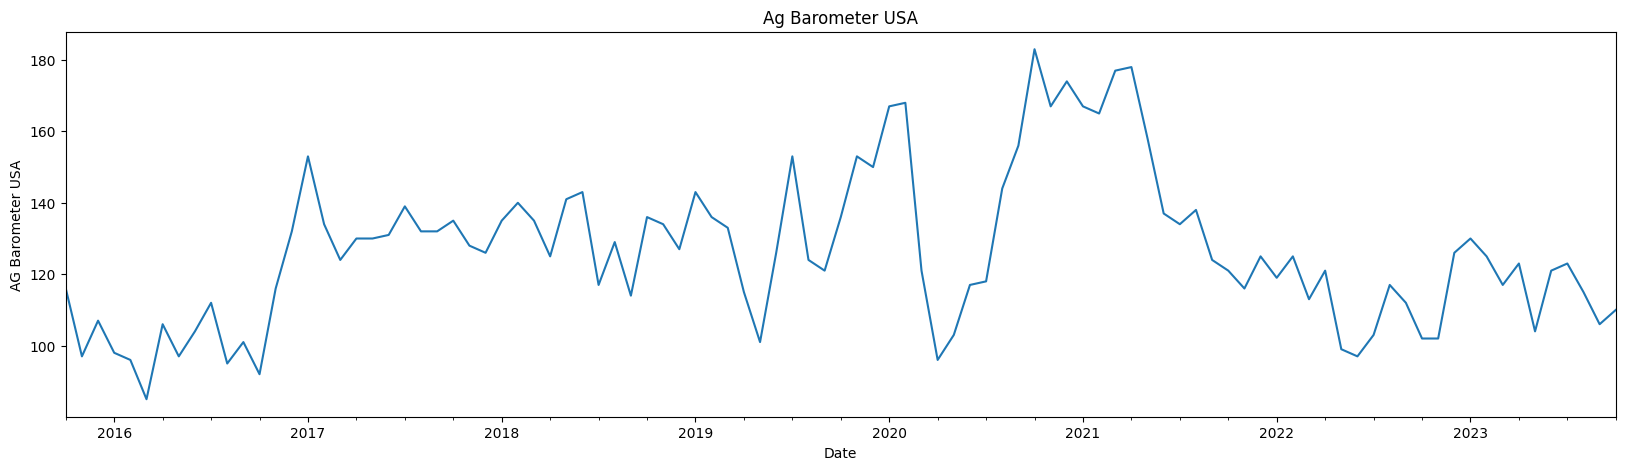

In [25]:
train2.plot(figsize=(20,5), title = "Ag Barometer USA", ylabel = "AG Barometer USA", xlabel = "Date")
plt.show()

In [26]:
#ICG UTDT

df_ICG = pd.read_csv('../data/clean_data/ICG_cleaned.csv')
print(df_ICG.head())

  indicator        date  value
0       ICG  2001-11-01  1.036
1       ICG  2001-12-01  0.757
2       ICG  2002-01-01  1.357
3       ICG  2002-02-01  0.983
4       ICG  2002-03-01  0.862


In [27]:
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   indicator  288 non-null    object 
 1   date       288 non-null    object 
 2   value      288 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.9+ KB


In [28]:
df_ICG['date'] = pd.to_datetime(df_ICG['date'], format='%Y-%m-%d')
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   indicator  288 non-null    object        
 1   date       288 non-null    datetime64[ns]
 2   value      288 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.9+ KB


In [29]:
df_ICG.set_index('date', inplace=True)
print(df_ICG.head())

           indicator  value
date                       
2001-11-01       ICG  1.036
2001-12-01       ICG  0.757
2002-01-01       ICG  1.357
2002-02-01       ICG  0.983
2002-03-01       ICG  0.862


In [30]:
data3 = df_ICG['value']

In [31]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 28 y 31 dias

df_time_diffs = data3.index.to_series().diff()
print(df_time_diffs.value_counts())

date
31 days    167
30 days     96
28 days     18
29 days      6
Name: count, dtype: int64


In [32]:
# Asignamos frecuencia mensual
data3 = data3.asfreq('MS')

# Corroboramos que la frecuencia sea mensual
print(data3.index)

DatetimeIndex(['2001-11-01', '2001-12-01', '2002-01-01', '2002-02-01',
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01',
               ...
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01'],
              dtype='datetime64[ns]', name='date', length=288, freq='MS')


In [33]:
# Dividimos en train y test
# Seleccionamos el primer 80% para train
train3 = data3.iloc[:round(len(data3)*.8)]
# Seleccionamos el 20% restante para test
test3 = data3.iloc[round(len(data3)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train3, test3)

date
2001-11-01    1.036000
2001-12-01    0.757000
2002-01-01    1.357000
2002-02-01    0.983000
2002-03-01    0.862000
                ...   
2020-08-01    2.377858
2020-09-01    2.265969
2020-10-01    1.992344
2020-11-01    2.019343
2020-12-01    1.853868
Freq: MS, Name: value, Length: 230, dtype: float64 date
2021-01-01    1.875130
2021-02-01    1.816565
2021-03-01    1.783856
2021-04-01    1.732998
2021-05-01    1.932057
2021-06-01    1.703405
2021-07-01    1.698242
2021-08-01    1.852228
2021-09-01    1.579328
2021-10-01    1.524077
2021-11-01    1.453584
2021-12-01    1.422823
2022-01-01    1.543808
2022-02-01    1.494021
2022-03-01    1.507731
2022-04-01    1.436073
2022-05-01    1.303236
2022-06-01    1.401616
2022-07-01    1.116667
2022-08-01    1.182577
2022-09-01    1.230554
2022-10-01    1.281745
2022-11-01    1.189553
2022-12-01    1.251266
2023-01-01    1.274121
2023-02-01    1.171330
2023-03-01    1.177622
2023-04-01    1.070521
2023-05-01    1.132271
2023-06-01    1.119

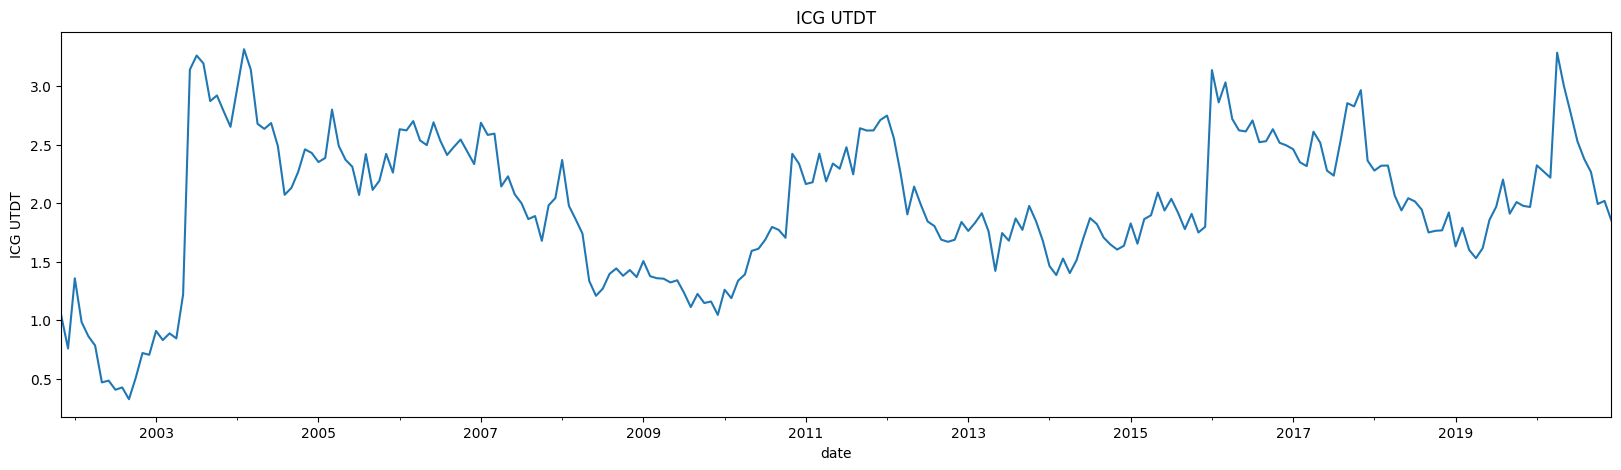

In [34]:
train3.plot(figsize=(20,5), title = "ICG UTDT", ylabel = "ICG UTDT", xlabel = "date")
plt.show()

En este apartado se presentan las siguientes series, en orden:

- Ag Barometer AR
- Ag Barometer USA
- ICG

La primera parece tener una componente de tendencia, aparentemente lineal, lo que implicaría que la serie no es estacionaria. Pero al tener esta leve tendencia y, visualmente, no notarse ciclos, con una diferenciación tal vez pueda ser necesario para hacer a la misma estacionaria.

Para Ag Baromemter USA, la seria aparenta ser estacionaria. Tal vez puede existir una leve componente de tendencia o alguna variación en variabilidad pero, a priori, se asemeja mucho a una estacionaria. Para ese caso no necesitariamos diferenciación.

Por otro lado, tenemos el ICG, que a simple vista no parece ser estacionaria. Si bien podriamos pensar en cierta oscilación sobre una valor medio, parece tener ciclos de picos y valles, con saltos absolutos marcados sobre años de elecciones presidenciales. En este caso, una prueba a hacer sería diferenciar entre los valores del ciclo, para reducir dicha estacionalidad.

In [35]:
# Serie a data frame
df_ciclos = train3.to_frame(name='ICG')

# Filtrado
fecha_inicio_ciclos = pd.to_datetime('2003-12-01')
df_ciclos = df_ciclos.loc[df_ciclos.index >= fecha_inicio_ciclos].copy()

# Construcción de los gobiernos
diff_meses = (
    (df_ciclos.index.year - fecha_inicio_ciclos.year) * 12 +
    (df_ciclos.index.month - fecha_inicio_ciclos.month)
)

periodo_ciclo = 48 # 4 años * 12 meses

df_ciclos['Ciclo'] = (diff_meses // periodo_ciclo) + 1

condiciones = [
    (df_ciclos['Ciclo'] == 1),
    (df_ciclos['Ciclo'] == 2),
    (df_ciclos['Ciclo'] == 3),
    (df_ciclos['Ciclo'] == 4),
    (df_ciclos['Ciclo'] == 5),
    (df_ciclos['Ciclo'] == 6)        
                 
]

valores_salida = ['NK', 'CFK 1', 'CFK 2', 'Macri', 'Alberto', 'Milei']

df_ciclos['Ciclo'] = np.select(
    condiciones, 
    valores_salida,
    default = 'NA'
)

df_ciclos['Mes_en_Ciclo'] = (diff_meses % periodo_ciclo) + 1


# Chequeo
print("--- DataFrame con Ciclos de 4 Años (Meses 1, 47, 48) ---")
print(df_ciclos[['ICG', 'Ciclo', 'Mes_en_Ciclo']].head(50)) 
print("\n--- Final del Último Ciclo ---")
print(df_ciclos[['ICG', 'Ciclo', 'Mes_en_Ciclo']].tail(5))

--- DataFrame con Ciclos de 4 Años (Meses 1, 47, 48) ---
                 ICG  Ciclo  Mes_en_Ciclo
date                                     
2003-12-01  2.652758     NK             1
2004-01-01  2.985494     NK             2
2004-02-01  3.316432     NK             3
2004-03-01  3.141597     NK             4
2004-04-01  2.678145     NK             5
2004-05-01  2.635284     NK             6
2004-06-01  2.684965     NK             7
2004-07-01  2.488041     NK             8
2004-08-01  2.071303     NK             9
2004-09-01  2.130540     NK            10
2004-10-01  2.267291     NK            11
2004-11-01  2.460088     NK            12
2004-12-01  2.429269     NK            13
2005-01-01  2.351252     NK            14
2005-02-01  2.386628     NK            15
2005-03-01  2.799647     NK            16
2005-04-01  2.489071     NK            17
2005-05-01  2.370627     NK            18
2005-06-01  2.311147     NK            19
2005-07-01  2.069969     NK            20
2005-08-01  2.42008

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1738518073.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Spectral', num_ciclos)


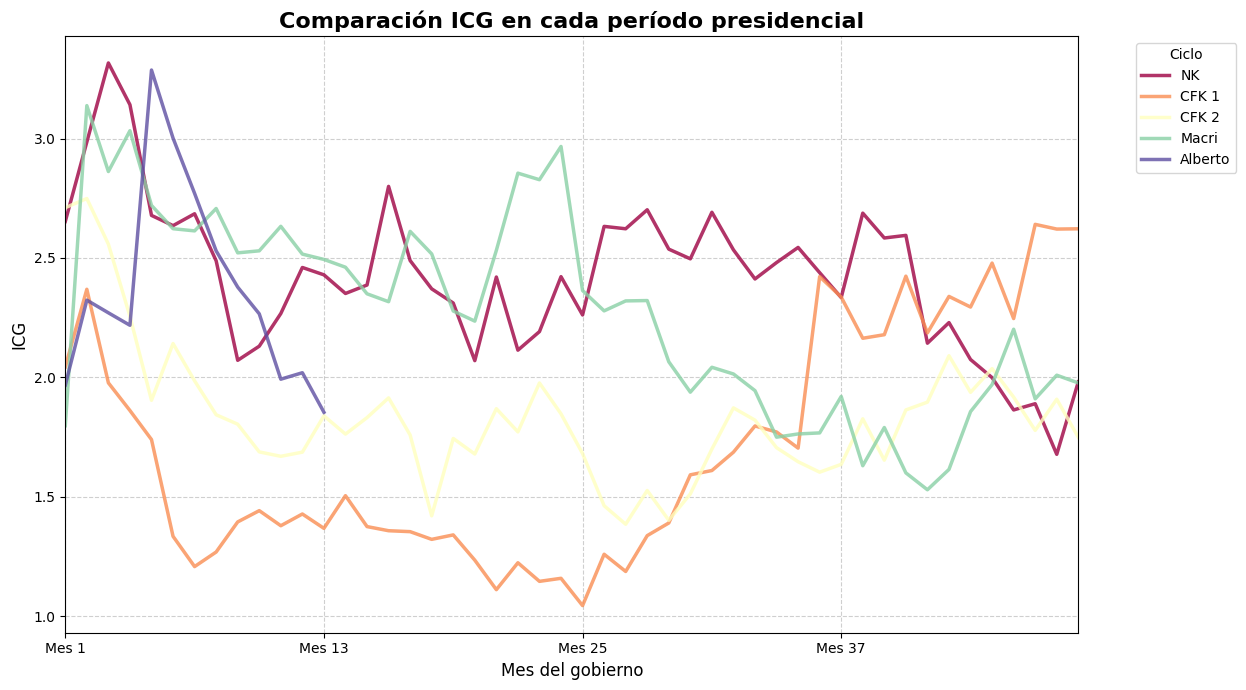

In [36]:


# Obtener los ciclos únicos para iterar y asignar colores
ciclos_unicos = df_ciclos['Ciclo'].unique()
num_ciclos = len(ciclos_unicos)

# Usar un mapa de colores (colormap) de Matplotlib (e.g., 'viridis', 'tab10', 'Spectral')
colors = cm.get_cmap('Spectral', num_ciclos) 

# Construcción del gráfico
plt.figure(figsize=(14, 7))
ax = plt.gca() # Obtener el objeto axes actual

# Iterar y Graficar cada Ciclo
for i, ciclo in enumerate(ciclos_unicos):

    data_ciclo = df_ciclos[df_ciclos['Ciclo'] == ciclo]
    
    ax.plot(
        data_ciclo['Mes_en_Ciclo'], 
        data_ciclo['ICG'],       
        label=f'{ciclo}',    
        color=colors(i),            
        linewidth=2.5,
        alpha=0.8
    )

# Configuración del Gráfico
plt.title('Comparación ICG en cada período presidencial', fontsize=16, fontweight='bold')
plt.xlabel('Mes del gobierno', fontsize=12)
plt.ylabel('ICG', fontsize=12)


meses_anuales = [1, 13, 25, 37]
plt.xticks(meses_anuales, [f'Mes {m}' for m in meses_anuales])
plt.xlim(1, 48)


plt.legend(title='Ciclo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# 3 Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría. 

In [37]:
# Grafica de ACF, PACF y autocovarianza
def graficar_acf_pacf_autocovarianza(data, lags=10):
    Y = data.values

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))


    sm.graphics.tsa.plot_acf(Y, lags=lags, ax=ax[0])
    ax[0].set_title('Funcion de autocorrelación (ACF)')

    sm.graphics.tsa.plot_pacf(Y, lags=lags, ax=ax[1])
    ax[1].set_title('Funcion de autocorrelación Parcial (grafico introductorio) (PACF)')

    def autocovariance(series, lag):
        series_mean = np.mean(series)
        n = len(series)
        return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

    lags = np.arange(lags)
    autocov = [autocovariance(Y, lag) for lag in lags]

    ax[2].stem(lags, autocov)
    ax[2].set_title('Autocovarianza')
    ax[2].set_xlabel('Lag')
    ax[2].set_ylabel('Autocovarianza')

    plt.tight_layout();
    plt.show();

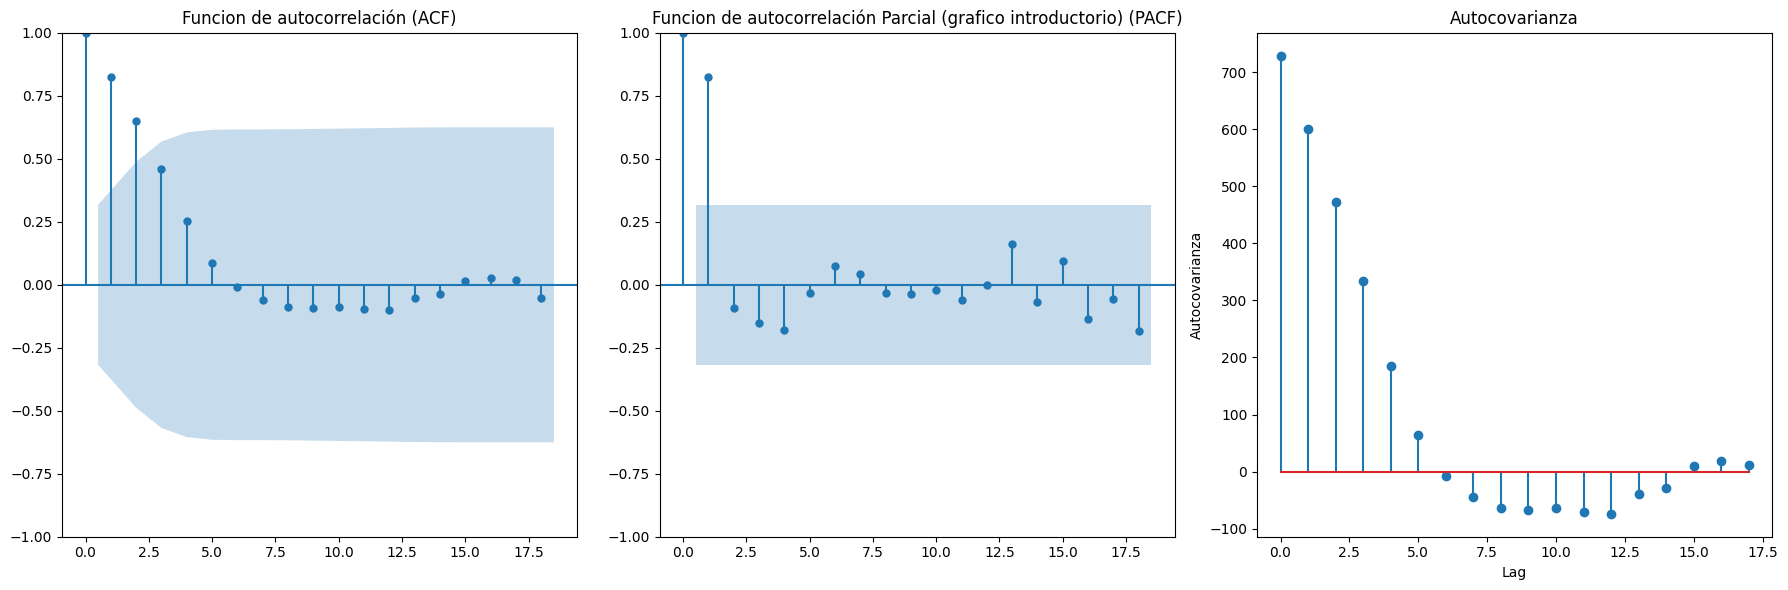

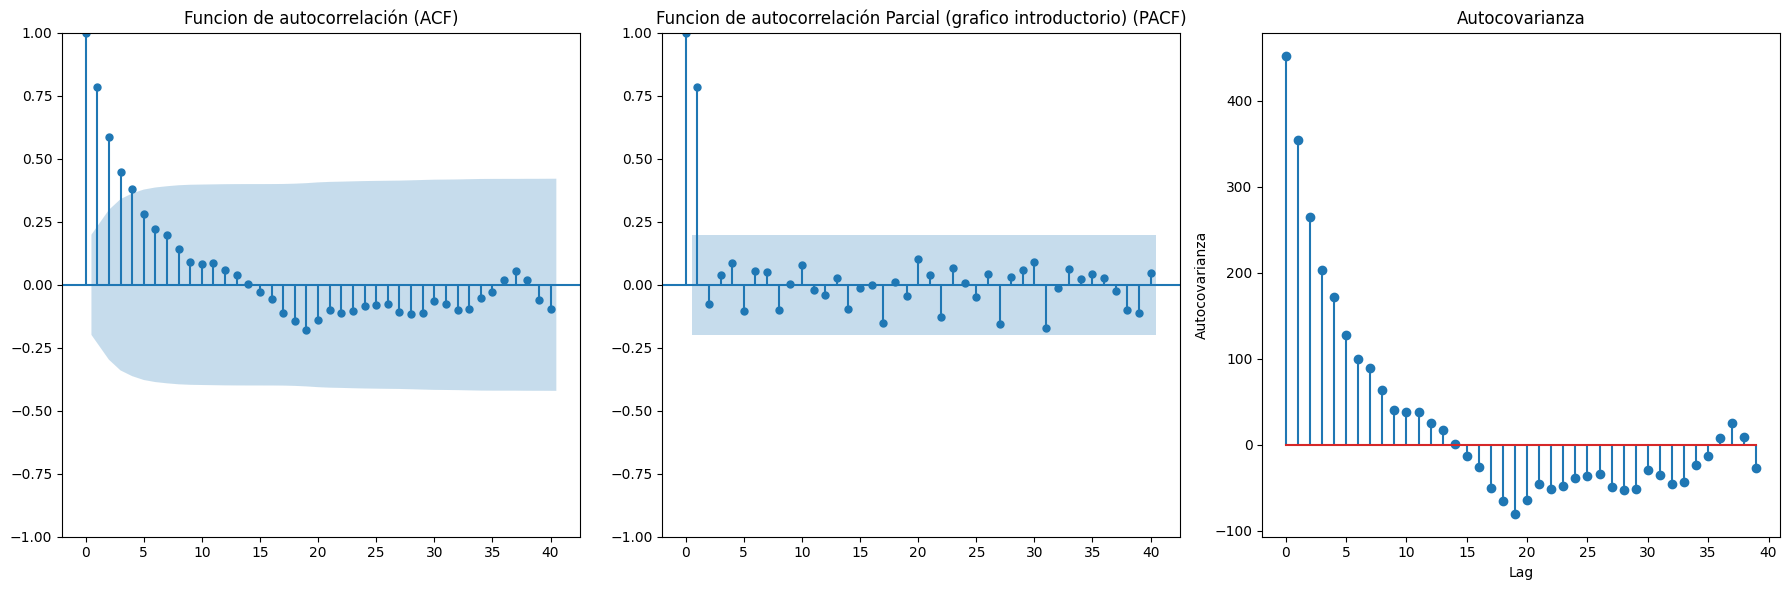

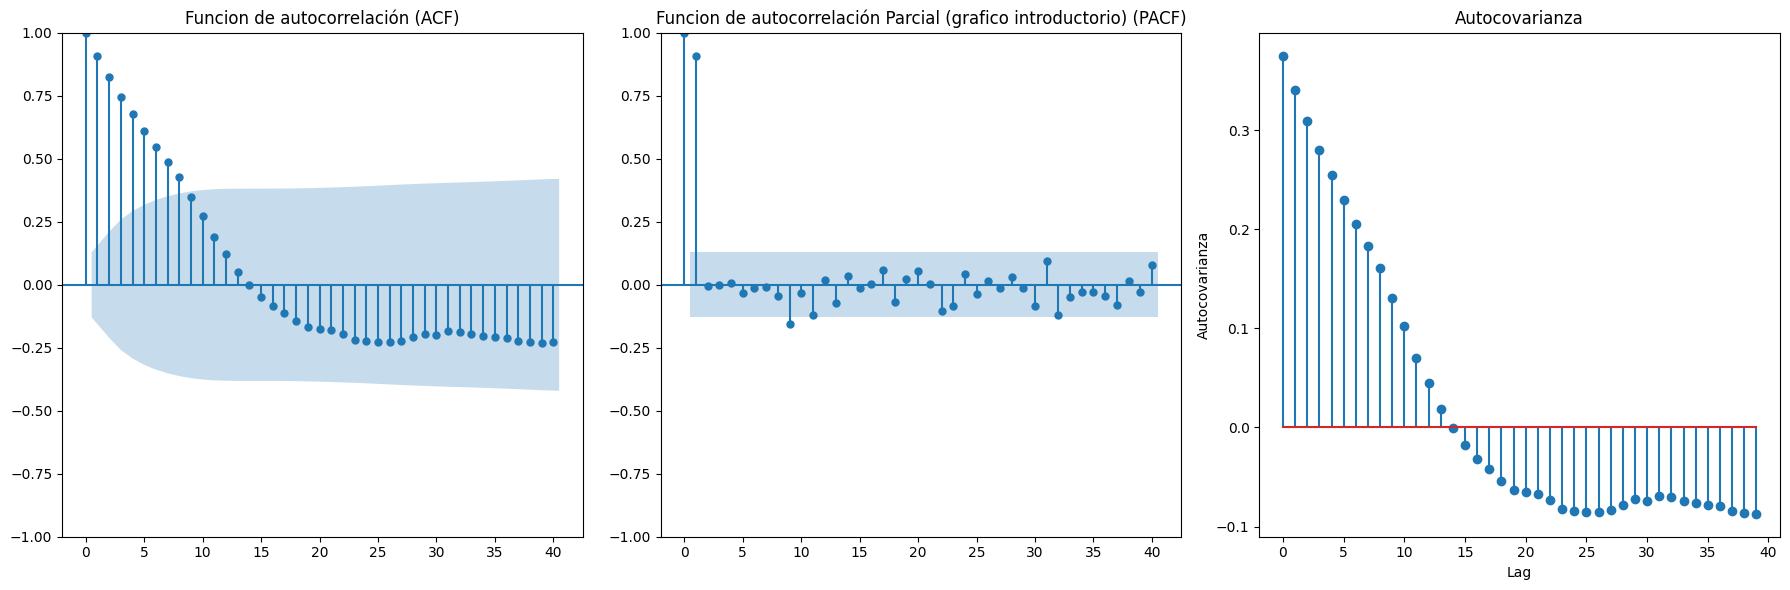

In [38]:
graficar_acf_pacf_autocovarianza(train1, lags=18)
graficar_acf_pacf_autocovarianza(train2, lags=40)
graficar_acf_pacf_autocovarianza(train3, lags=40)

En el caso del Ag Barometer AR podemos ver un decaimiento que aparenta ser lineal, lo que ya nos puede hacer pensar en que no tenemos estacionariedad. A su vez, vemos una fuerte autocorrelación parcial con el primer rezago, haciendonos pensar en una componente autorregresiva de orden 1.

El caso del Ag Barometer USA podría indicarnos una serie estacionaria, donde se nota un decaimiento exponencial en el correlograma, con memoria relativamente corta. A su vez, otra vez visualizando la autocorrelación parcial, podemos pensar en una autocorrelación de orden 1. Con todo esto, pensamos que un primer modelo de aproximación podría ser un AR(1)

Para el caso del ICG, vemos más una caida lineal de la autocorrelación y algunos rezagos estadísticamente significativos en la autocorrelación parcial. Este es el caso más dificil de interpretar, ya que la supuesta estacionalidad marcada tampoco se ve muy notoriamente en estos gráficos

In [39]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

In [40]:
print_test_afd(train1)
print_test_afd(train2)
print_test_afd(train3)

Estadistico ADF: -1.269719
p-valor: 0.642910
Valores criticos:
	1%: -3.654
	5%: -2.957
	10%: -2.618
Estadistico ADF: -3.310231
p-valor: 0.014427
Valores criticos:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Estadistico ADF: -3.409435
p-valor: 0.010641
Valores criticos:
	1%: -3.459
	5%: -2.874
	10%: -2.574


Recordando que el test de Dickey-Fuller involucra:

- H0: existencia de raiz unitaria
- Ha: no existencia de raiz unitaria

Dados los p valores de los test a las 3 series, podemos decir que:

- Para AG Barometer AR, no podemos rechazar la H0, o sea, la no estacionariedad
- Para AG Barometer USA e ICG, se presenta evidencia estadística para rechazar H0 y afirmar que presentan estacionariedad

In [41]:
# Diferenciación de la serie del Agbarometer AR
data1_diferenciada = data1 - data1.shift(1)

# eliminamos el NA inicial
data1_diferenciada = data1_diferenciada.dropna()

# Dividimos en train y test
# Seleccionamos el primer 90% para train
train1_dif = data1_diferenciada.iloc[:round(len(data1)*.9)]
# Seleccionamos el 10% restante para test
test1_dif = data1_diferenciada.iloc[round(len(data1)*.9):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train1_dif, test1_dif)

Bimestre
2019-01-01    11.0
2019-03-01    -3.0
2019-05-01    14.0
2019-07-01    20.0
2019-09-01   -63.0
2019-11-01   -10.0
2020-01-01   -12.0
2020-03-01     0.5
2020-05-01    -2.0
2020-07-01    -2.5
2020-09-01    21.0
2020-11-01     9.0
2021-01-01     1.0
2021-03-01    11.0
2021-05-01   -11.0
2021-07-01   -10.0
2021-09-01    10.0
2021-11-01     0.0
2022-01-01    11.0
2022-03-01     0.0
2022-05-01     8.0
2022-07-01   -22.0
2022-09-01     7.0
2022-11-01   -16.0
2023-01-01     1.0
2023-03-01     1.0
2023-05-01    15.0
2023-07-01     5.0
2023-09-01    11.0
2023-11-01    17.0
2024-01-01     2.0
2024-03-01    10.0
2024-05-01    10.0
2024-07-01     0.0
2024-09-01    -7.0
2024-11-01    17.0
2025-01-01   -32.0
2025-03-01    20.0
Freq: 2MS, Name: Ag Barometer, dtype: float64 Bimestre
2025-05-01   -7.0
2025-07-01   -3.0
2025-09-01   -3.0
Freq: 2MS, Name: Ag Barometer, dtype: float64


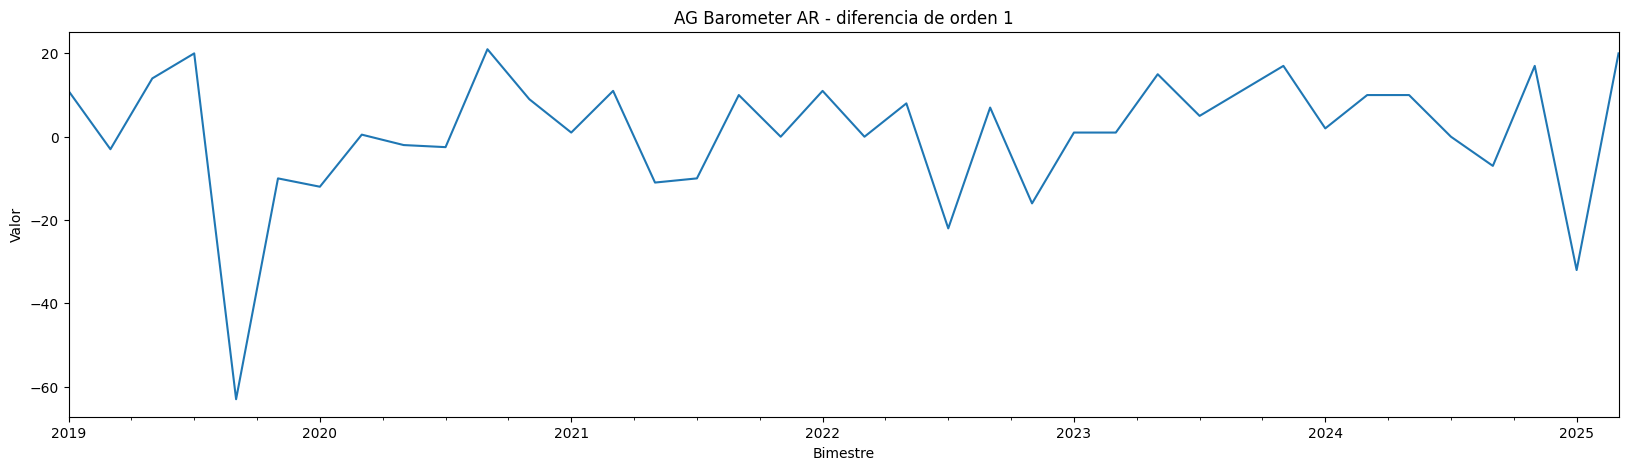

In [42]:
train1_dif.plot(figsize=(20,5), title = "AG Barometer AR - diferencia de orden 1", ylabel = "Valor", xlabel = "Bimestre")
plt.show()

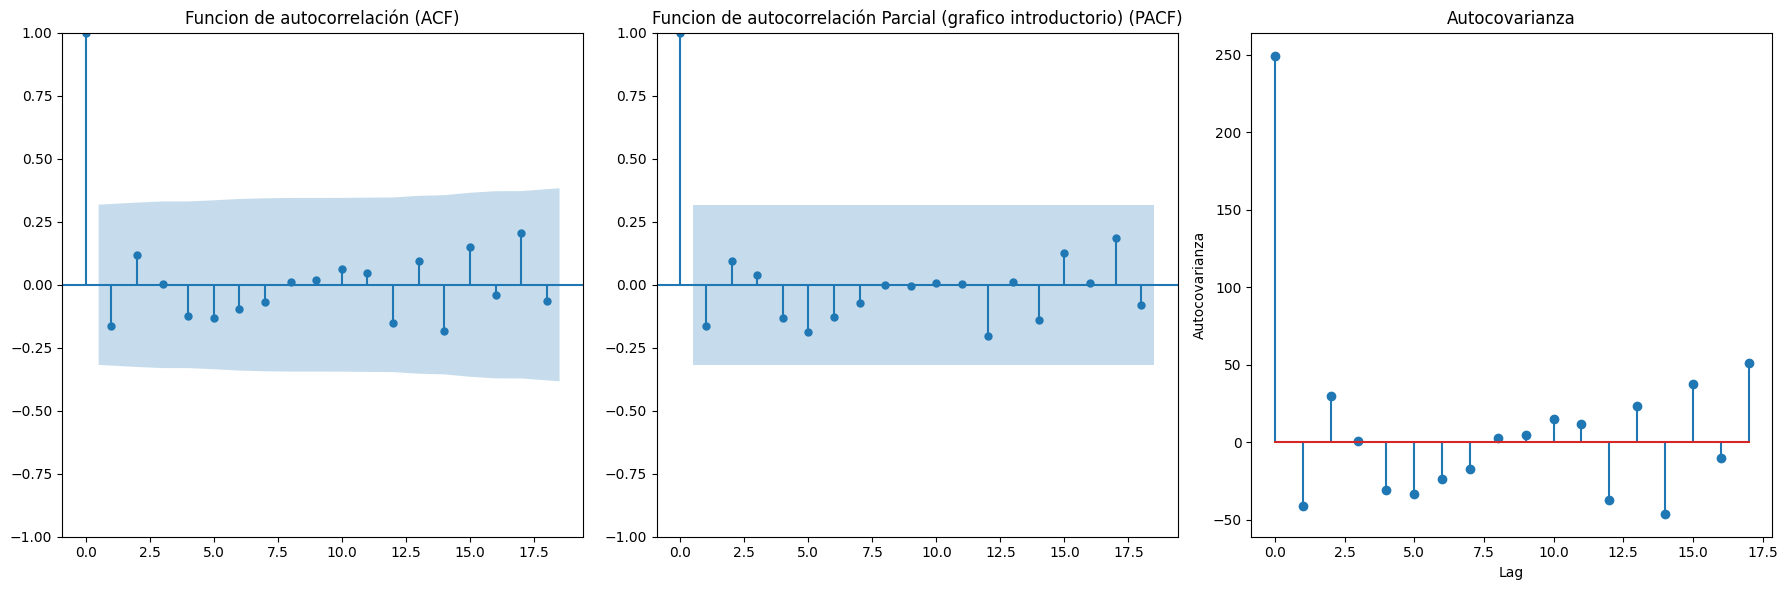

In [43]:
graficar_acf_pacf_autocovarianza(train1_dif, lags=18)

In [44]:
print_test_afd(train1_dif)

Estadistico ADF: -3.461011
p-valor: 0.009047
Valores criticos:
	1%: -3.646
	5%: -2.954
	10%: -2.616


Al hacer la diferencia de orden 1 se puede ver que se obtuvo una serie estacionaria pero que en principio la misma parece ser ruido blanco ya que no tenemos autocovariancias significativas ni en la FAC ni en la FACP

# 4 Planteo de modelos

In [45]:
# Funciones
def graficar_pred(serie_test, serie_pred, conf_int, ylabel, titulo="Valores Originales vs Predicciones", xlabel="Mes"):
    
    # 1. Configurar la figura y los ejes (Estética 1: figsize y sin axes)
    plt.figure(figsize=(12, 4)) # Cambiado de (12, 3) y se omite la creación manual de axes_x
    plt.title(titulo, fontsize=16) # Estética 2: Título más grande
    plt.xlabel(xlabel, fontsize=12) # Estética 3: Fuente más grande
    plt.ylabel(ylabel, fontsize=12) # Estética 3: Fuente más grande
    plt.grid(True, linestyle='--', alpha=0.7) # Estética 4: Estilo de grilla más sutil

    # 2. Graficamos los datos tests y las predicciones (Mismas llamadas, diferente estética)
    # Valores Reales
    plt.plot(serie_test.index, serie_test.values, label='Valores Reales (Test)', 
             color='darkblue', marker='o', linewidth=2)
    
    # Predicciones
    plt.plot(serie_pred.index, serie_pred.values, label='Predicción (Modelo)', 
             color='red', linestyle='--', linewidth=2) # Estética 5: Color y estilo específicos

    # 3. Graficar el Intervalo de Confianza (Usando fill_between)
    # Rellenar el área entre el límite inferior (col 0) y el límite superior (col 1)
    plt.fill_between(
        conf_int.index,
        conf_int.iloc[:, 0], # Límite inferior
        conf_int.iloc[:, 1], # Límite superior
        color='red', 
        alpha=0.2, 
        label='Intervalo de Confianza (95%)' # Se añade etiqueta al área sombreada
    )

    # 4. Configuración final
    plt.legend(loc='upper left', fontsize=10) # Estética 6: Posición de la leyenda
    plt.tight_layout() # Asegura que los elementos no se solapen
    plt.show() # Muestra el gráfico


def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')


## 4.1 Ag Barometer AR

In [46]:
stepwise_fit = auto_arima(train1_dif, trace=True,suppress_warnings=True, stepwise = False, seasonal=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=319.721, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=320.894, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=321.888, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=323.887, Time=0.19 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=326.150, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=320.688, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=322.410, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=323.888, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=327.564, Time=0.85 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=322.161, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=324.155, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=325.574, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[0]             :

En este caso autoarima confirma lo mencionado anteriormente, ya que obtenemos que el mejor modelo es un AR(0), es decir el ruido blanco 

In [47]:
modelo1 = sm.tsa.arima.ARIMA(train1_dif, order=(1,0,0))

resultado1 = modelo1.fit()

resultado1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Ag Barometer   No. Observations:                   38
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -158.239
Date:                Mon, 22 Dec 2025   AIC                            322.478
Time:                        19:03:01   BIC                            327.391
Sample:                    01-01-2019   HQIC                           324.226
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9956      3.013      0.330      0.741      -4.911       6.902
ar.L1         -0.1676      0.145     -1.155      0.248      -0.452       0.117
sigma2       242.2032     50.259      4.819      0.000     143.697     340.710
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                45.15
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -1.71
Prob(H) (two-sided):                  0.11   Kurtosis:                         7.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
modelo2 = sm.tsa.arima.ARIMA(train1_dif, order=(0,0,1))

resultado2 = modelo2.fit()

resultado2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Ag Barometer   No. Observations:                   38
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -158.340
Date:                Mon, 22 Dec 2025   AIC                            322.680
Time:                        19:03:02   BIC                            327.593
Sample:                    01-01-2019   HQIC                           324.428
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0177      3.066      0.332      0.740      -4.992       7.028
ma.L1         -0.1359      0.168     -0.811      0.418      -0.464       0.193
sigma2       243.5687     55.491      4.389      0.000     134.808     352.329
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                46.65
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -1.72
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Con estas corridas confirmamos que aún los modelos más simples como el MA(1) y el AR(1) no resultan adecuados ya que los coeficientes asociados a dichos modelos son NO significativos

### Modelos con predictoras

Si bien la serie resultó ser ruido blanco, se quiere analizar si su comportamiento guarda relación con otras variables. En ese sentido, se van a considerar el Agbarometer USA, el ICG de la UTDT, la brecha entre el dolar oficial y el mep, el REM de la inflación y el precio de la soja en chicago. 

In [49]:
df_dolar = pd.read_csv('../data/clean_data/dolar_full_cleaned.csv') 

df_dolar['Brecha %'] = df_dolar['brecha']/df_dolar['oficial']

df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha'], format='%Y-%m-%d')

df_dolar = df_dolar[
    (df_dolar['fecha'] >= '2018-11-01') &
    (df_dolar['fecha'] <= '2025-09-01')
].copy()

df_dolar.set_index('fecha', inplace=True)

dolar = df_dolar['Brecha %']

# Asignamos frecuencia bimestral
dolar = dolar.asfreq('2MS')

In [50]:
df_soja = pd.read_csv('../data/clean_data/precio_soja_chicago_cleaned.csv') 

df_soja['date'] = pd.to_datetime(df_soja['date'], format='%Y-%m-%d')

df_soja.set_index('date', inplace=True)

soja = df_soja['Close']

# Asignamos frecuencia diaria
soja = soja.asfreq('D')

# Completamos los datos
soja = soja.ffill()

# Nos quedamos con los datos del inicio de cada bimestre
soja = soja[soja.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
soja = soja.asfreq('2MS')

In [51]:
df_rem = pd.read_csv('../data/clean_data/rem_cleaned.csv') 

df_rem['Fecha'] = pd.to_datetime(df_rem['Fecha'], format='%Y-%m-%d')

df_rem['Fecha'] = df_rem['Fecha'] + pd.Timedelta(days=1)

df_rem.set_index('Fecha', inplace=True)

rem = df_rem['Valor']

# Nos quedamos con los datos del inicio de cada bimestre
rem = rem[rem.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
rem = rem.asfreq('2MS')

In [52]:
agbarometerUSA = data2[data2.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
agbarometerUSA = agbarometerUSA.asfreq('2MS')

ICG = data3[data3.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
ICG = ICG.asfreq('2MS')

In [53]:
data_completa = pd.concat([data1, agbarometerUSA, dolar, rem, soja, ICG], axis=1)

data_completa.rename(columns={'Ag Barometer': 'Ag Barometer AR', 'Purdue/CME Ag Economy Barometer': 'Ag Barometer USA', 'Brecha %': 'Brecha', 'Valor': 'REM', 'Close': 'Soja', 'value': 'ICG'},
                     inplace = True)

In [54]:
# Dividimos en train y test
# Seleccionamos el primer 90% para train
full_train = data_completa.iloc[:round(len(data_completa)*.9)]
# Seleccionamos el 10% restante para test
full_test = data_completa.iloc[round(len(data_completa)*.9):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(full_train, full_test)

            Ag Barometer AR  Ag Barometer USA    Brecha    REM     Soja  \
2018-11-01             95.0               134  0.001467   30.6   869.00   
2019-01-01            106.0               143  0.002881   28.7   882.50   
2019-03-01            103.0               133  0.003480   29.0   899.25   
2019-05-01            117.0               101 -0.001728   31.4   839.50   
2019-07-01            137.0               153 -0.001109   30.0   885.50   
2019-09-01             74.0               121  0.118759   48.3   857.00   
2019-11-01             64.0               153  0.215209   48.2   924.25   
2020-01-01             52.0               167  0.316240   42.2   943.00   
2020-03-01             52.5               121  0.360243   39.9   883.50   
2020-05-01             50.5               103  0.670553   49.0   847.25   
2020-07-01             48.0               118  0.568141   52.5   893.75   
2020-09-01             69.0               156  0.679726   51.2   955.00   
2020-11-01             78

In [55]:
modelo_ARIMAX = sm.tsa.ARIMA(full_train['Ag Barometer AR'], order=(0,1,0), exog=full_train[['Ag Barometer USA']])

resultado_ARIMAX = modelo_ARIMAX.fit()

resultado_ARIMAX.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Ag Barometer AR   No. Observations:                   38
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -151.586
Date:                Mon, 22 Dec 2025   AIC                            307.171
Time:                        19:03:02   BIC                            310.393
Sample:                    11-01-2018   HQIC                           308.307
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Ag Barometer USA     0.2666      0.128      2.089      0.037       0.016       0.517
sigma2             211.8640     39.601      5.350      0.000     134.247     289.481
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                39.77
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -1.69
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

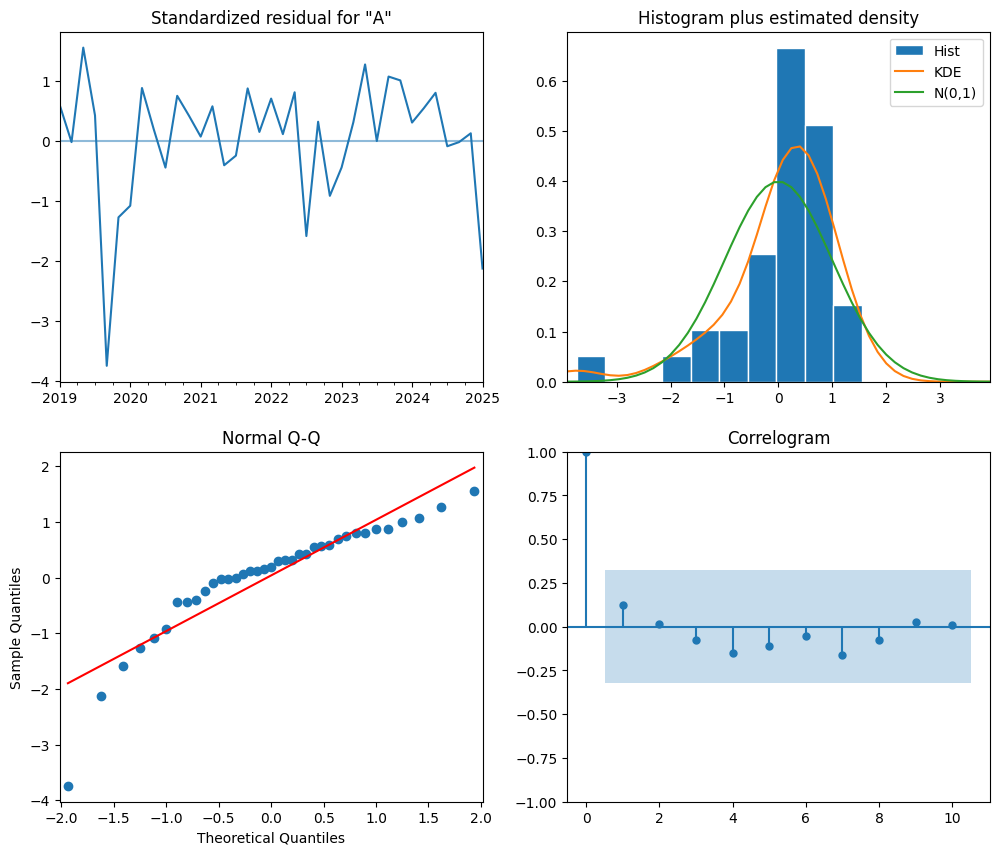

In [56]:
fig_res_AR1 = resultado_ARIMAX.plot_diagnostics(figsize=(12,10))

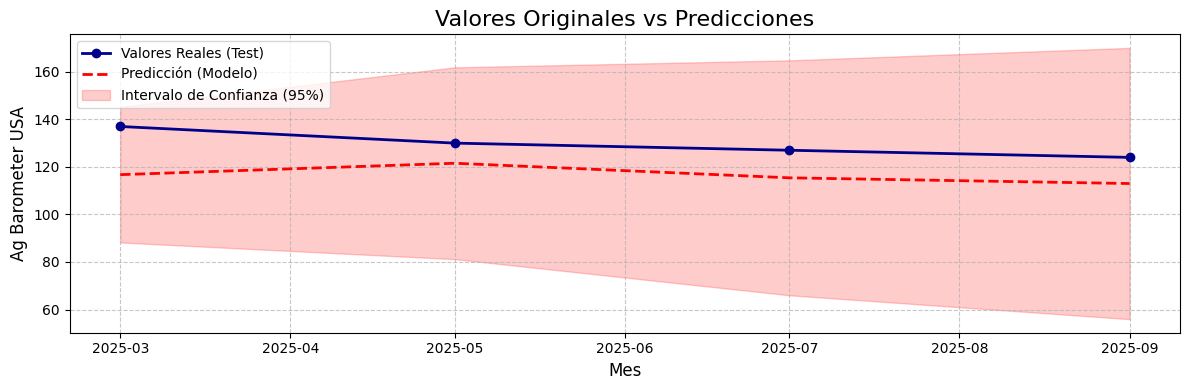

In [57]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
predicciones = resultado_ARIMAX.get_forecast(len(full_test), exog = full_test["Ag Barometer USA"])

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(full_test['Ag Barometer AR'], predicciones.predicted_mean, predicciones.conf_int(), ylabel="Ag Barometer USA")

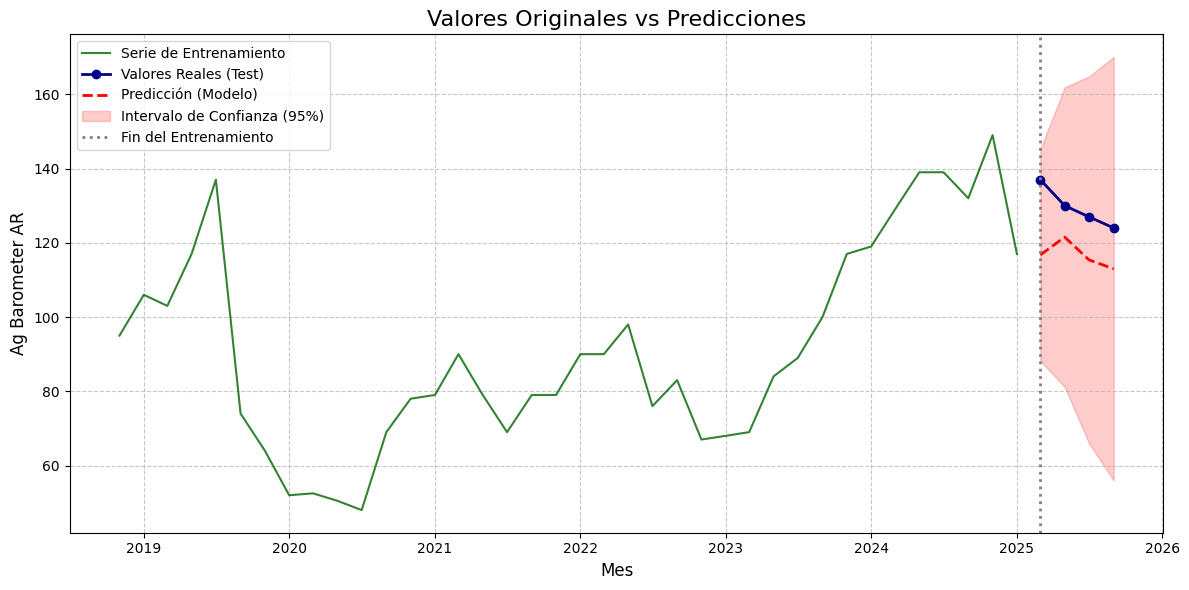

In [58]:
def graficar_pred_con_contexto(serie_train, serie_test, serie_pred, conf_int, ylabel, titulo="Valores Originales vs Predicciones", xlabel="Mes"):
    """
    Genera un gráfico que compara la serie de entrenamiento (contexto histórico), 
    los valores reales de prueba, las predicciones y el intervalo de confianza.
    """
    
    # 1. Configurar la figura y los ejes
    plt.figure(figsize=(12, 6)) 
    plt.title(titulo, fontsize=16) 
    plt.xlabel(xlabel, fontsize=12) 
    plt.ylabel(ylabel, fontsize=12) 
    plt.grid(True, linestyle='--', alpha=0.7) 

    # 2. Graficar la serie de ENTRENAMIENTO (El nuevo argumento)
    plt.plot(serie_train.index, serie_train.values, label='Serie de Entrenamiento', 
             color='darkgreen', linewidth=1.5, alpha=0.8) # Estilo para el contexto histórico

    # 3. Graficar los valores reales de prueba
    plt.plot(serie_test.index, serie_test.values, label='Valores Reales (Test)', 
             color='darkblue', marker='o', linewidth=2)
    
    # 4. Graficar la predicción puntual
    plt.plot(serie_pred.index, serie_pred.values, label='Predicción (Modelo)', 
             color='red', linestyle='--', linewidth=2) 

    # 5. Graficar el Intervalo de Confianza (Usando fill_between)
    # Rellenar el área entre el límite inferior (col 0) y el límite superior (col 1)
    plt.fill_between(
        conf_int.index,
        conf_int.iloc[:, 0], # Límite inferior
        conf_int.iloc[:, 1], # Límite superior
        color='red', 
        alpha=0.2, 
        label='Intervalo de Confianza (95%)' 
    )

    # 6. Añadir una línea vertical para marcar el punto de quiebre (opcional pero muy útil)
    # Esta línea separa el entrenamiento del test/predicción
    if serie_test.index.min() > serie_train.index.max():
        fecha_corte = serie_test.index.min()
    else:
        # Esto ocurre si y_test comienza inmediatamente después del último punto de y_train
        fecha_corte = serie_train.index.max()
        
    plt.axvline(fecha_corte, color='gray', linestyle=':', linewidth=2, label='Fin del Entrenamiento')

    # 7. Configuración final
    plt.legend(loc='upper left', fontsize=10) 
    plt.tight_layout()
    plt.show()

graficar_pred_con_contexto(full_train['Ag Barometer AR'], full_test['Ag Barometer AR'], predicciones.predicted_mean, predicciones.conf_int(), ylabel="Ag Barometer AR")

In [59]:
evaluar_metricas(test1, predicciones.predicted_mean)

MSE: 184.49289656624256
MAE: 12.833273403060982
RMSE: 13.582816223679188
MAPE: 0.0983


## 4.2 Ag Barometer USA

In [60]:
stepwise_fit = auto_arima(train2, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=786.937, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=872.420, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=781.329, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=817.103, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1219.117, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=782.960, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=782.938, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=784.969, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.289 seconds


Dada la salida del auto_arima, se entrenarán 3 modelos candidatos para compararlos AR(1), AR(2) y ARMA(1,1)


In [61]:
modelo1 = sm.tsa.arima.ARIMA(train2, order=(1,0,0))

resultado1 = modelo1.fit()

resultado1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     Purdue/CME Ag Economy Barometer   No. Observations:                   97
Model:                              ARIMA(1, 0, 0)   Log Likelihood                -387.662
Date:                             Mon, 22 Dec 2025   AIC                            781.324
Time:                                     19:03:07   BIC                            789.048
Sample:                                 10-01-2015   HQIC                           784.447
                                      - 10-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.6416      6.344     19.804      0.000     113.207     138.076
ar.L1          0.7835      0.059     13.228      0.000       0.667       0.900
sigma2       171.6338     25.404      6.756      0.000     121.844     221.424
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.57   Prob(JB):                         0.97
Heteroskedasticity (H):               0.90   Skew:                            -0.04
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
modelo2 = sm.tsa.arima.ARIMA(train2, order=(2,0,0))

resultado2 = modelo2.fit()

resultado2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     Purdue/CME Ag Economy Barometer   No. Observations:                   97
Model:                              ARIMA(2, 0, 0)   Log Likelihood                -387.479
Date:                             Mon, 22 Dec 2025   AIC                            782.959
Time:                                     19:03:07   BIC                            793.257
Sample:                                 10-01-2015   HQIC                           787.123
                                      - 10-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.8358      5.962     21.107      0.000     114.151     137.521
ar.L1          0.8320      0.096      8.625      0.000       0.643       1.021
ar.L2         -0.0619      0.092     -0.673      0.501      -0.242       0.118
sigma2       170.9741     26.019      6.571      0.000     119.978     221.970
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.92   Prob(JB):                         0.94
Heteroskedasticity (H):               0.89   Skew:                            -0.05
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:

modelo3 = sm.tsa.arima.ARIMA(train2, order=(1,0,1))

resultado3 = modelo3.fit()

resultado3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     Purdue/CME Ag Economy Barometer   No. Observations:                   97
Model:                              ARIMA(1, 0, 1)   Log Likelihood                -387.469
Date:                             Mon, 22 Dec 2025   AIC                            782.938
Time:                                     19:03:07   BIC                            793.237
Sample:                                 10-01-2015   HQIC                           787.102
                                      - 10-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.8265      5.976     21.055      0.000     114.114     137.539
ar.L1          0.7520      0.075     10.050      0.000       0.605       0.899
ma.L1          0.0821      0.119      0.692      0.489      -0.150       0.315
sigma2       170.9599     25.901      6.600      0.000     120.194     221.725
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.93   Prob(JB):                         0.94
Heteroskedasticity (H):               0.89   Skew:                            -0.04
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Al trabajar con los modelos más complejos se ve que los coeficientes que se agregan no son significativos, por lo que se continuará trabajando con el AR(1) al cual se le hará un análisis mas detallado de los residuos

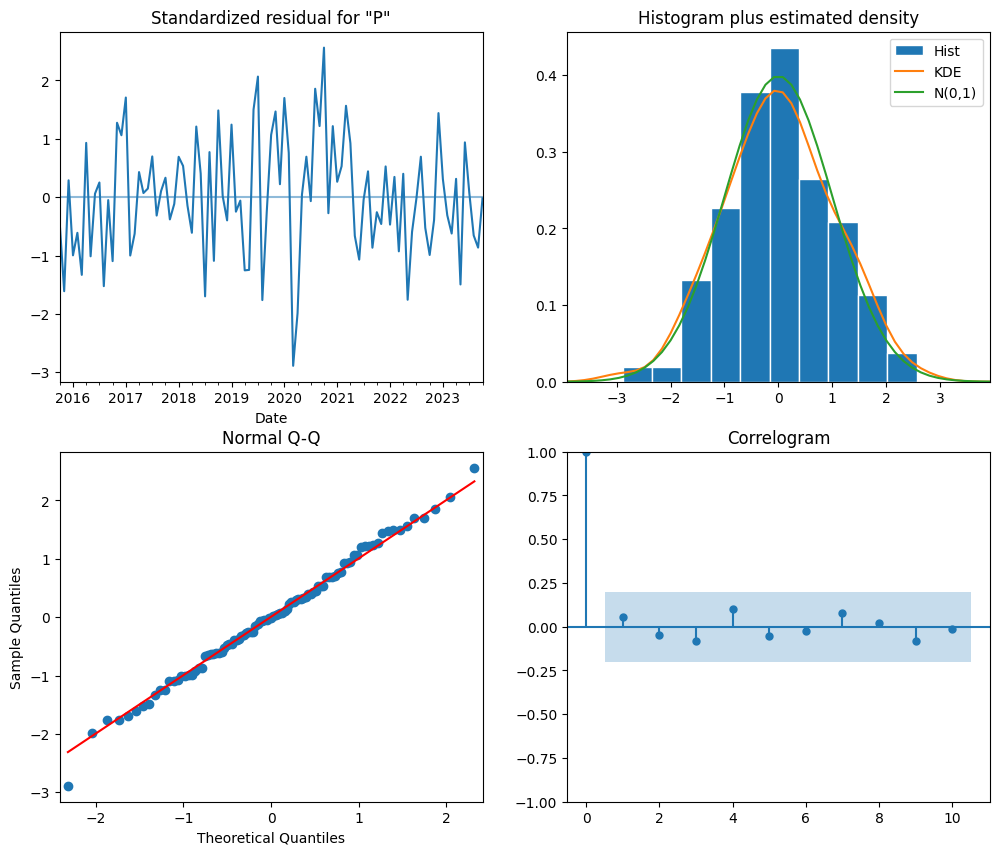

In [64]:
# Agregar análisis punto pandemia
fig_res_AR1 = resultado1.plot_diagnostics(figsize=(12,10))

Al analizar el comportamiento de los residuos con mayor detalle, se observa que los mismos están incorrelacionados (p-value Ljung-Box = 0.57) y al analizar tanto el test de Jarque Bera como el histograma y el gráfico QQ Normal se ve que el supuesto de normalidad se cumple



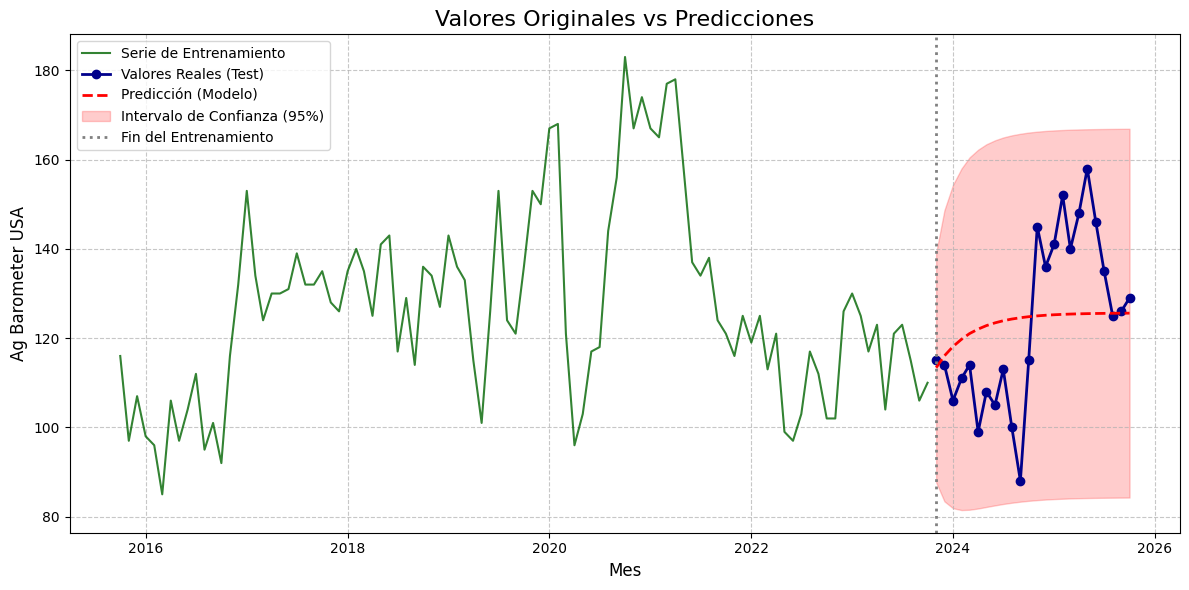

In [65]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
predicciones = resultado1.get_forecast(len(test2))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred_con_contexto(train2, test2, predicciones.predicted_mean, predicciones.conf_int(), ylabel="Ag Barometer USA")


In [66]:
evaluar_metricas(test2, predicciones.predicted_mean)


MSE: 303.686392147698
MAE: 14.444208028143905
RMSE: 17.426600131629176
MAPE: 0.1202



El gráfico de las predicciones  del modelo muestra un comportamiento totalmente esperado en base al modelo ajustado. Como se trabajó con un AR(1) se hace una predicción del promedio pero no se logran captar los movimientos que el índice presenta mes a mes 

## Rolling Forecast

In [67]:
# Ajustamos el modelo con la librería pmdarima para poder hacer rolling forecast sin reentrenar
modelo1_pmd = pm.ARIMA(order=(1, 0, 0))

resultado1_pmd = modelo1_pmd.fit(train2) 

print(resultado1_pmd.summary())

# Aseguramos que trabajamos con el modelo original de pmdarima
modelo_rodante = resultado1_pmd 

# Listas para guardar los resultados
rolling_predictions = []
lower_bounds = []
upper_bounds = []

# Obtenemos el índice de tiempo
test_indices = test2.index

# --- Bucle de Pronóstico Rodante USANDO .predict() ---
print("Iniciando Pronóstico Rodante Recursivo de 1 paso con .predict(return_conf_int=True)...")

for i in range(len(test2)):
    
    # 1. Realizar el pronóstico de 1 paso y obtener el intervalo de confianza (level=0.95 por defecto)
    # Importante: Este método devuelve un numpy array de pronósticos y un numpy array de CI.
    
    # Si su versión de pmdarima es reciente, debe desempaquetar DOS arrays:
    try:
        forecast, conf_int = modelo_rodante.predict(n_periods=1, return_conf_int=True)
        
    # Si su versión de pmdarima es antigua o el wrapper falla, solo devuelve el array de pronósticos.
    except ValueError:
        # Si falla el desempaquetado, use solo .predict() para el valor,
        # y use .get_forecast() con try/except para el CI si es necesario, pero es riesgoso.
        # POR SIMPLICIDAD Y ROBUSTEZ, usaremos el .predict() simple para el valor puntual
        # y forzaremos el uso del wrapper para el CI si el desempaquetado falla (aunque esto es menos ideal).
        print("Advertencia: Falló el desempaquetado. Solo obteniendo el pronóstico puntual.")
        forecast = modelo_rodante.predict(n_periods=1)
        conf_int = np.array([[np.nan, np.nan]]) # Rellenar con NaN si falla el CI
    
    # 2. Desempaquetar los resultados
    prediccion_puntual = forecast[0]
    limite_inferior = conf_int[0, 0]
    limite_superior = conf_int[0, 1]
    
    # El valor real que se acaba de observar
    actual_value = test2[i]
    
    # 3. Guardar los resultados
    rolling_predictions.append(prediccion_puntual)
    lower_bounds.append(limite_inferior)
    upper_bounds.append(limite_superior)
    
    # 4. ACTUALIZAR el modelo con el nuevo valor real (El método nativo de pmdarima)
    modelo_rodante.update(actual_value) 
    
    print(f"Paso {i+1}: Pronóstico={prediccion_puntual:.2f}, Real={actual_value:.2f}, CI_95%=[{limite_inferior:.2f}, {limite_superior:.2f}]")

# --- 5. Crear un DataFrame de resultados ---
results_df = pd.DataFrame({
    'Real': test2.values, 
    'Pronostico': rolling_predictions,
    'CI_Inferior_95': lower_bounds,
    'CI_Superior_95': upper_bounds
}, index=test_indices) 

print("\n--- Resultados Finales del Pronóstico Rodante ---")
print(results_df)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -387.664
Date:                Mon, 22 Dec 2025   AIC                            781.329
Time:                        19:03:10   BIC                            789.053
Sample:                    10-01-2015   HQIC                           784.452
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.6510      7.933      3.360      0.001      11.103      42.199
ar.L1          0.7877      0.059     13.297      0.000       0.672       0.904
sigma2       171.5735     25.385      6.759      0.0

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion_puntual = forecast[0]
C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_value = test2[i]
c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FBorbiconi\App

Paso 6: Pronóstico=116.33, Real=99.00, CI_95%=[90.96, 141.70]
Paso 7: Pronóstico=104.44, Real=108.00, CI_95%=[79.08, 129.80]
Paso 8: Pronóstico=111.50, Real=105.00, CI_95%=[86.21, 136.80]
Paso 9: Pronóstico=109.09, Real=113.00, CI_95%=[83.89, 134.29]
Paso 10: Pronóstico=115.40, Real=100.00, CI_95%=[90.29, 140.50]
Paso 11: Pronóstico=105.13, Real=88.00, CI_95%=[80.04, 130.22]
Paso 12: Pronóstico=95.64, Real=115.00, CI_95%=[70.55, 120.72]
Paso 13: Pronóstico=116.89, Real=145.00, CI_95%=[91.77, 142.02]
Paso 14: Pronóstico=140.58, Real=136.00, CI_95%=[115.33, 165.83]


C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_value = test2[i]
c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_value = test2[i]
c:\Users\FBorbiconi\OneDrive - U

Paso 15: Pronóstico=133.51, Real=141.00, CI_95%=[108.18, 158.85]
Paso 16: Pronóstico=137.56, Real=152.00, CI_95%=[112.20, 162.93]
Paso 17: Pronóstico=146.39, Real=140.00, CI_95%=[121.00, 171.77]
Paso 18: Pronóstico=136.88, Real=148.00, CI_95%=[111.49, 162.27]
Paso 19: Pronóstico=143.30, Real=158.00, CI_95%=[117.92, 168.69]
Paso 20: Pronóstico=151.36, Real=146.00, CI_95%=[125.97, 176.74]


C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_value = test2[i]
c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_value = test2[i]
c:\Users\FBorbiconi\OneDrive - U

Paso 21: Pronóstico=141.81, Real=135.00, CI_95%=[116.43, 167.19]
Paso 22: Pronóstico=133.05, Real=125.00, CI_95%=[107.69, 158.40]
Paso 23: Pronóstico=125.08, Real=126.00, CI_95%=[99.79, 150.37]
Paso 24: Pronóstico=125.87, Real=129.00, CI_95%=[100.65, 151.09]

--- Resultados Finales del Pronóstico Rodante ---
            Real  Pronostico  CI_Inferior_95  CI_Superior_95
Date                                                        
2023-11-01   115  113.301720       87.628920      138.974521
2023-12-01   114  117.233553       91.573741      142.893365
2024-01-01   106  116.447444       91.021423      141.873466
2024-02-01   111  110.061373       84.647359      135.475386
2024-03-01   114  113.987609       88.590888      139.384329
2024-04-01    99  116.332660       90.962675      141.702645
2024-05-01   108  104.440838       79.083619      129.798057
2024-06-01   105  111.502713       86.205098      136.800328
2024-07-01   113  109.091282       83.893458      134.289105
2024-08-01   100  1

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_value = test2[i]
c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_29412\1428979927.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_value = test2[i]
c:\Users\FBorbiconi\OneDrive - U

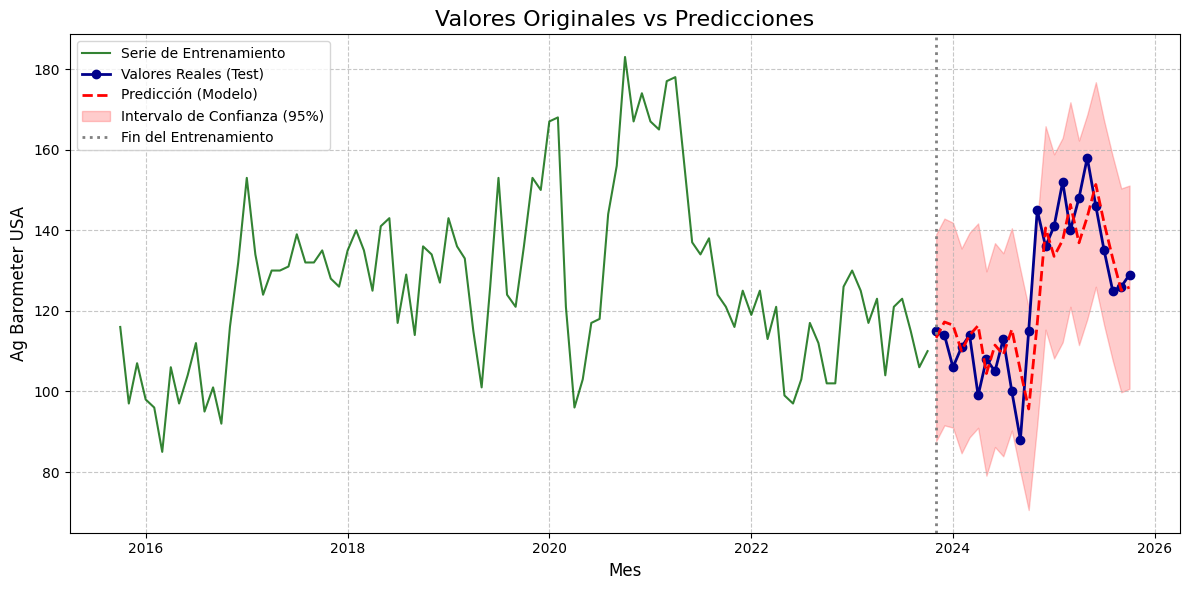

In [68]:
# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred_con_contexto(train2, test2, results_df['Pronostico'], results_df[['CI_Inferior_95', 'CI_Superior_95']], ylabel="Ag Barometer USA")


In [69]:
evaluar_metricas(test2, results_df['Pronostico'])

MSE: 125.2366648089379
MAE: 8.774886102550342
RMSE: 11.190918854541744
MAPE: 0.0727


Tanto en el gráfico como en las métricas puede observarse que con un enfoque de predicción rodante se obtienen mejores resultados que con predicciones a largo plazo del modelo original. Sin embargo, el modelo responde lento a los cambios de tendencia, viendose este efecto de manera clara entre finales de 2024 y principio del 2025

## 4.3 ICG UTDT

In [70]:
stepwise_fit = auto_arima(train3, trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=27.593, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=431.316, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22.899, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=243.756, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=993.101, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24.837, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.840, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=25.646, Time=0.68 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.877 seconds


In [71]:
modelo1 = sm.tsa.arima.ARIMA(train3, order=(1,0,0))

resultado1 = modelo1.fit()

resultado1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  230
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  -8.449
Date:                Mon, 22 Dec 2025   AIC                             22.899
Time:                        19:03:15   BIC                             33.213
Sample:                    11-01-2001   HQIC                            27.059
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9484      0.219      8.907      0.000       1.520       2.377
ar.L1          0.9139      0.031     29.764      0.000       0.854       0.974
sigma2         0.0625      0.003     23.475      0.000       0.057       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              2826.12
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             2.82
Prob(H) (two-sided):                  0.11   Kurtosis:                        19.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
modelo2 = sm.tsa.arima.ARIMA(train3, order=(2,0,0))

resultado2 = modelo2.fit()

resultado2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  230
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  -8.418
Date:                Mon, 22 Dec 2025   AIC                             24.837
Time:                        19:03:15   BIC                             38.589
Sample:                    11-01-2001   HQIC                            30.384
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9467      0.222      8.755      0.000       1.511       2.382
ar.L1          0.8988      0.077     11.748      0.000       0.749       1.049
ar.L2          0.0165      0.072      0.231      0.817      -0.124       0.157
sigma2         0.0625      0.003     20.790      0.000       0.057       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2898.88
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             2.84
Prob(H) (two-sided):                  0.10   Kurtosis:                        19.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
modelo3 = sm.tsa.arima.ARIMA(train3, order=(1,0,1))

resultado3 = modelo3.fit()

resultado3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  230
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  -8.420
Date:                Mon, 22 Dec 2025   AIC                             24.840
Time:                        19:03:15   BIC                             38.593
Sample:                    11-01-2001   HQIC                            30.388
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9468      0.222      8.761      0.000       1.511       2.382
ar.L1          0.9168      0.031     29.359      0.000       0.856       0.978
ma.L1         -0.0170      0.078     -0.217      0.828      -0.171       0.136
sigma2         0.0625      0.003     20.802      0.000       0.057       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2894.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             2.84
Prob(H) (two-sided):                  0.10   Kurtosis:                        19.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

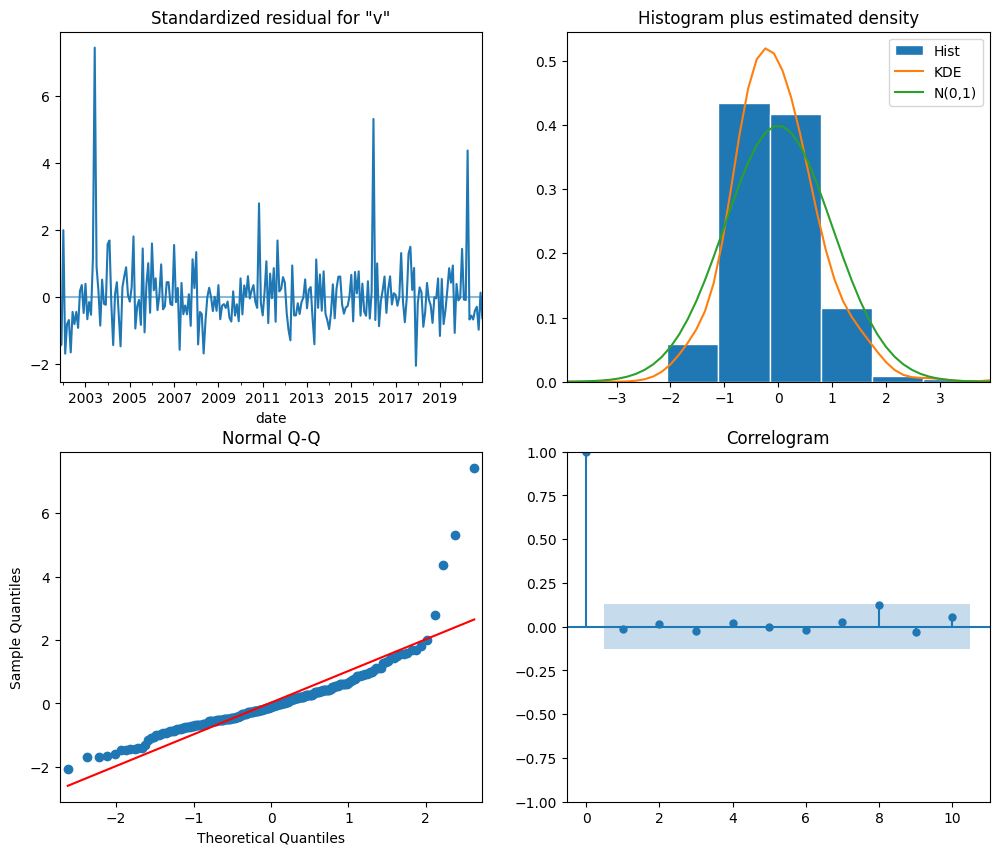

In [74]:
# Agregar análisis punto pandemia
fig_res_AR1 = resultado1.plot_diagnostics(figsize=(12,10))

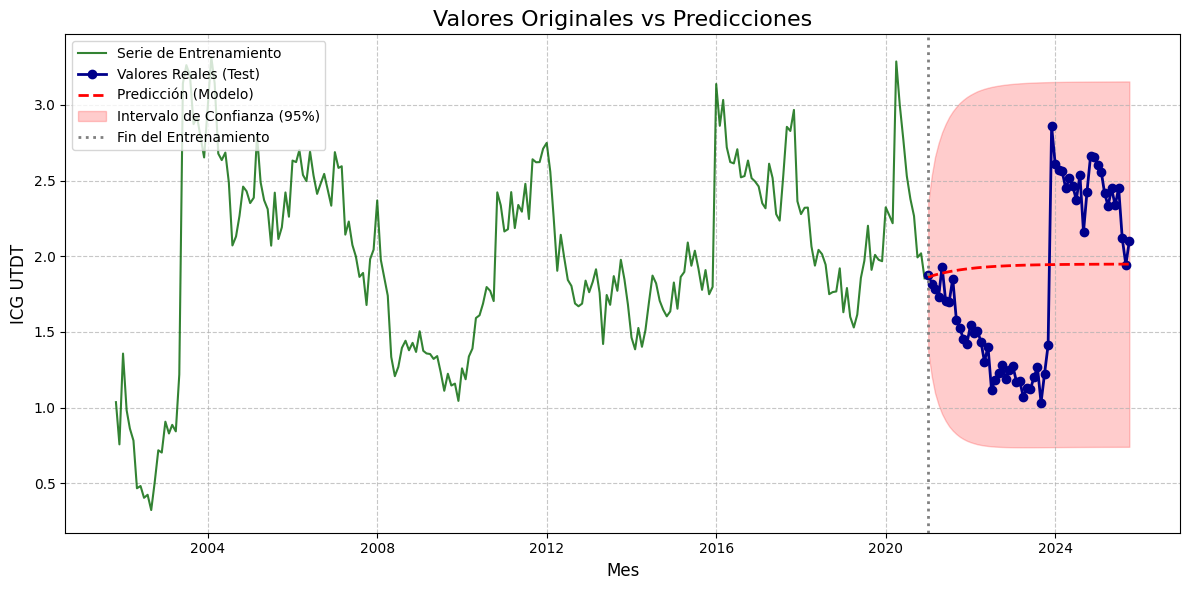

In [75]:
# Utilizando el modelo realizamos la prediccion correspondiente al periodo de test
predicciones = resultado1.get_forecast(len(test3))

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred_con_contexto(train3, test3, predicciones.predicted_mean, predicciones.conf_int(), ylabel="ICG UTDT")

El modelo AR(1) fue el único con coeficientes significativos, pero no cumple la condición de normalidad. Al ver las predicciones a largo plazo (quizás demasiado y tengo que corregir) se ve que predice un valor promedio, sobreestimando al final del gobierno de Alberto y subestimando en los primeros 2 años de Milei. 

In [76]:
evaluar_metricas(test3, predicciones.predicted_mean)

MSE: 0.3162847662631974
MAE: 0.5058453035706051
RMSE: 0.5623920040889605
MAPE: 0.3244


## Predicción en base a variables externas

Para predecir el comportamiento del ICG se tendrán en cuenta 3 variables, la cotización del dolar oficial, el índice CER como proxy de la inflación y la cotización de la soja.

In [77]:
df_dolar = pd.read_csv('../data/clean_data/dolar_oficial_completo_cleaned.csv') 

df_dolar['Fecha'] = pd.to_datetime(df_dolar['Fecha'], format='%Y-%m-%d')

df_dolar.set_index('Fecha', inplace=True)

dolar = df_dolar['Valor']

# Asignamos frecuencia diaria
dolar = dolar.asfreq('D')

# Completamos los datos
dolar = dolar.ffill()

# Nos quedamos con los datos del inicio de cada mes
dolar = dolar[dolar.index.isin(data3.index)]

# Asignamos frecuencia mensual
dolar = dolar.asfreq('MS')

print(dolar)

Fecha
2002-04-01       2.85
2002-05-01       2.92
2002-06-01       3.58
2002-07-01       3.79
2002-08-01       3.63
               ...   
2025-06-01    1195.33
2025-07-01    1203.00
2025-08-01    1361.33
2025-09-01    1371.17
2025-10-01    1423.83
Freq: MS, Name: Valor, Length: 283, dtype: float64


In [78]:
df_cer = pd.read_csv('../data/clean_data/cer_cleaned.csv') 

df_cer['Fecha'] = pd.to_datetime(df_cer['Fecha'], format='%Y-%m-%d')

df_cer.set_index('Fecha', inplace=True)

cer = df_cer['Valor']

# Nos quedamos con los datos del inicio de cada mes
cer = cer[cer.index.isin(data3.index)]

# Asignamos frecuencia mensual
cer = cer.asfreq('MS')

# Calculamos la tasa de cambio mes a mes para tener un proxy de la inflación
cer = cer/cer.shift(1)
cer = cer.dropna()
print(cer)

Fecha
2002-04-01    1.030041
2002-05-01    1.038220
2002-06-01    1.093363
2002-07-01    1.050378
2002-08-01    1.036851
                ...   
2025-06-01    1.032619
2025-07-01    1.020622
2025-08-01    1.015776
2025-09-01    1.017644
2025-10-01    1.018711
Freq: MS, Name: Valor, Length: 283, dtype: float64


In [79]:
df_soja = pd.read_csv('../data/clean_data/precio_soja_chicago_completo_cleaned.csv') 

df_soja['date'] = pd.to_datetime(df_soja['date'], format='%Y-%m-%d')

df_soja.set_index('date', inplace=True)

soja = df_soja['Close']

# Asignamos frecuencia diaria
soja = soja.asfreq('D')

# Completamos los datos
soja = soja.ffill()

# Nos quedamos con los datos del inicio de cada mes
soja = soja[soja.index.isin(data3.index)]

# Asignamos frecuencia mensual
soja = soja.asfreq('MS')
print(soja)

date
2002-04-01     474.25
2002-05-01     460.25
2002-06-01     508.75
2002-07-01     549.50
2002-08-01     568.50
               ...   
2025-06-01    1041.75
2025-07-01    1024.75
2025-08-01     961.75
2025-09-01    1036.75
2025-10-01    1013.00
Freq: MS, Name: Close, Length: 283, dtype: float64


In [80]:
data3.name = 'ICG'
dolar.name = 'Dolar oficial'
cer.name = 'CER'
soja.name = 'Soja'

data_completa_2 = pd.concat([data3, dolar, cer, soja], axis=1)

data_completa_2 = data_completa_2.dropna()

In [81]:
data_completa_2

,ICG,Dolar oficial,CER,Soja
2002-04-01,0.782000,2.85,1.030041,474.25
2002-05-01,0.467000,2.92,1.038220,460.25
2002-06-01,0.482000,3.58,1.093363,508.75
2002-07-01,0.404000,3.79,1.050378,549.50
2002-08-01,0.424000,3.63,1.036851,568.50
...,...,...,...,...
2025-06-01,2.336000,1195.33,1.032619,1041.75
2025-07-01,2.451000,1203.00,1.020622,1024.75
2025-08-01,2.118000,1361.33,1.015776,961.75
2025-09-01,1.943966,1371.17,1.017644,1036.75


In [82]:
# Dividimos en train y test
# Seleccionamos el primer 80% para train
full_train = data_completa_2.iloc[:round(len(data_completa_2)*.8)]
# Seleccionamos el 20% restante para test
full_test = data_completa_2.iloc[round(len(data_completa_2)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(full_train, full_test)

                 ICG  Dolar oficial       CER     Soja
2002-04-01  0.782000           2.85  1.030041   474.25
2002-05-01  0.467000           2.92  1.038220   460.25
2002-06-01  0.482000           3.58  1.093363   508.75
2002-07-01  0.404000           3.79  1.050378   549.50
2002-08-01  0.424000           3.63  1.036851   568.50
...              ...            ...       ...      ...
2020-09-01  2.265969          74.25  1.020353   955.00
2020-10-01  1.992344          76.25  1.022970  1023.50
2020-11-01  2.019343          78.33  1.027959  1056.50
2020-12-01  1.853868          81.40  1.032893  1162.00
2021-01-01  1.875130          84.15  1.035285  1315.25

[226 rows x 4 columns]                  ICG  Dolar oficial       CER     Soja
2021-02-01  1.816565          87.61  1.036383  1365.25
2021-03-01  1.783856          90.09  1.038025  1392.50
2021-04-01  1.732998          91.99  1.039779  1402.00
2021-05-01  1.932057          93.56  1.041826  1571.00
2021-06-01  1.703405          94.74  1.04

In [83]:
modelo_ARIMAX = sm.tsa.ARIMA(full_train['ICG'], order=(1,0,0), exog=full_train[['Dolar oficial', 'CER', "Soja"]])

resultado_ARIMAX = modelo_ARIMAX.fit()

resultado_ARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ICG   No. Observations:                  226
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -27.709
Date:                Mon, 22 Dec 2025   AIC                             67.419
Time:                        19:03:19   BIC                             87.942
Sample:                    04-01-2002   HQIC                            75.701
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.0861      1.284     15.644      0.000      17.570      22.603
Dolar oficial     0.0056      0.006      1.006      0.314      -0.005       0.016
CER             -17.7076      1.260    -14.050      0.000     -20.178     -15.237
Soja             -0.0001      0.000     -0.573      0.567      -0.001       0.000
ar.L1             0.8699      0.038     22.911      0.000       0.795       0.944
sigma2            0.0756      0.004     18.453      0.000       0.068       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):              1035.62
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             1.96
Prob(H) (two-sided):                  0.12   Kurtosis:                        12.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Al hacer backward selection de los predictores del modelo, se observa que ninguna de las variables resulta significativa, por lo que se mantendrán las predicciones del modelo original

# Modelo VAR

#### 1. Selección de variables

Se usa el mismo ADF que ya definimos, pero variable por variable:

In [96]:
vars_var = ['Ag Barometer AR', 'Ag Barometer USA', 'Brecha', 'ICG']
var_data = data_completa[vars_var].dropna()

print("\n=== Matriz de correlación (nivel) ===")
print(var_data.corr())


=== Matriz de correlación (nivel) ===
                  Ag Barometer AR  Ag Barometer USA    Brecha       ICG
Ag Barometer AR          1.000000         -0.074807 -0.461709  0.287681
Ag Barometer USA        -0.074807          1.000000 -0.278509  0.254389
Brecha                  -0.461709         -0.278509  1.000000 -0.585315
ICG                      0.287681          0.254389 -0.585315  1.000000


Como primer análisis descriptivo, se presenta la matriz de correlación en nivel entre las variables consideradas. Se observa una correlación negativa moderada entre el Ag Barometer Argentina y la brecha cambiaria, lo que sugiere que mayores tensiones cambiarias se asocian con menores niveles de confianza en el sector agropecuario. Asimismo, la brecha presenta una relación negativa fuerte con el índice de confianza general (ICG), consistente con un deterioro de las expectativas económicas en contextos de inestabilidad cambiaria.

Por otro lado, la correlación contemporánea entre el Ag Barometer Argentina y el Ag Barometer USA resulta baja, indicando que la relación entre ambos indicadores no se manifiesta de forma inmediata, sino que podría operar con rezagos, aspecto que se analiza posteriormente mediante el modelo VAR.

#### 2. Test ADF (nivel) + Diferenciación + Test ADF (diferencias)

In [97]:
print("\n=== Test ADF por variable (nivel) ===")
for col in var_data.columns:
    print(f"\nVariable: {col}")
    print_test_afd(var_data[col])


=== Test ADF por variable (nivel) ===

Variable: Ag Barometer AR
Estadistico ADF: -0.959246
p-valor: 0.767837
Valores criticos:
	1%: -3.627
	5%: -2.946
	10%: -2.612

Variable: Ag Barometer USA
Estadistico ADF: -3.430721
p-valor: 0.009955
Valores criticos:
	1%: -3.601
	5%: -2.935
	10%: -2.606

Variable: Brecha
Estadistico ADF: -2.016923
p-valor: 0.279203
Valores criticos:
	1%: -3.601
	5%: -2.935
	10%: -2.606

Variable: ICG
Estadistico ADF: -1.869634
p-valor: 0.346478
Valores criticos:
	1%: -3.601
	5%: -2.935
	10%: -2.606


El test ADF aplicado a las series en nivel indica que el Ag Barometer Argentina, la brecha cambiaria y el ICG no son estacionarios, mientras que el Ag Barometer USA sí resulta estacionario en nivel. Dado que el modelo VAR requiere estacionariedad, se concluye que es necesario transformar las series antes de avanzar con el análisis multivariado.

In [102]:
print("\n=== Test ADF por variable (nivel) ===")
for col in var_data.columns:
    print(f"\nVariable: {col}")
    print_test_afd(var_data[col])

var_data_diff = var_data.diff().dropna()

var_data_diff['Ag Barometer USA'] = var_data['Ag Barometer USA'][1:]

print("\n=== Test ADF por variable (diferencias) ===")
for col in var_data_diff.columns:
    print(f"\nADF diferenciada - {col}")
    print_test_afd(var_data_diff[col])

print("\n=== Matriz de correlación (diferencias) ===")
print(var_data_diff.corr())


=== Test ADF por variable (nivel) ===

Variable: Ag Barometer AR
Estadistico ADF: -0.959246
p-valor: 0.767837
Valores criticos:
	1%: -3.627
	5%: -2.946
	10%: -2.612

Variable: Ag Barometer USA
Estadistico ADF: -3.430721
p-valor: 0.009955
Valores criticos:
	1%: -3.601
	5%: -2.935
	10%: -2.606

Variable: Brecha
Estadistico ADF: -2.016923
p-valor: 0.279203
Valores criticos:
	1%: -3.601
	5%: -2.935
	10%: -2.606

Variable: ICG
Estadistico ADF: -1.869634
p-valor: 0.346478
Valores criticos:
	1%: -3.601
	5%: -2.935
	10%: -2.606

=== Test ADF por variable (diferencias) ===

ADF diferenciada - Ag Barometer AR
Estadistico ADF: -3.558743
p-valor: 0.006601
Valores criticos:
	1%: -3.627
	5%: -2.946
	10%: -2.612

ADF diferenciada - Ag Barometer USA
Estadistico ADF: -2.668490
p-valor: 0.079651
Valores criticos:
	1%: -3.621
	5%: -2.944
	10%: -2.610

ADF diferenciada - Brecha
Estadistico ADF: -6.352945
p-valor: 0.000000
Valores criticos:
	1%: -3.610
	5%: -2.939
	10%: -2.608

ADF diferenciada - ICG
Esta

Luego de aplicar una diferenciación de primer orden, todas las series resultan estacionarias según el test ADF, por lo que se consideran adecuadas para la estimación del modelo VAR. Asimismo, la matriz de correlación en diferencias muestra relaciones contemporáneas de menor magnitud que en nivel, lo cual es consistente con la eliminación de tendencias comunes y refuerza el enfoque dinámico del análisis.

En función de estos resultados, el análisis VAR se realiza sobre las series en primera diferencia, a fin de estudiar las interacciones dinámicas de corto plazo entre las variables.

#### 3. Split Train/Test (90/10) (respetando tiempo)

In [104]:
train_size = round(len(var_data_diff) * 0.9)
train = var_data_diff.iloc[:train_size]
test  = var_data_diff.iloc[train_size:]

print("\nTamaños -> train:", train.shape, "| test:", test.shape)


Tamaños -> train: (37, 4) | test: (4, 4)


Las series diferenciadas se dividieron respetando el orden temporal, utilizando el 90% de las observaciones para entrenamiento (37) y el 10% para test (4).

#### 4. Selección de rezagos (mostrar criterios)

In [105]:
modelo_var = VAR(train)

print("\n=== Selección de rezagos (probar maxlags=1..4) ===")
sel_final = None
for m in range(1, 5):
    try:
        sel = modelo_var.select_order(maxlags=m)
        sel_final = sel
        print(f"\nmaxlags={m}")
        print(sel.summary())
    except ValueError as e:
        print(f"\nmaxlags={m} -> NO estimable: {e}")
        break

if sel_final is not None:
    print("\nLag sugerido por AIC:", sel_final.aic)
    print("Lag sugerido por BIC:", sel_final.bic)

print("\nDecisión: se estima VAR(1) (muestra chica + objetivo dinámico).")


=== Selección de rezagos (probar maxlags=1..4) ===

maxlags=1
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       6.728      6.904*       835.2       6.789
1      6.479*       7.358      655.8*      6.786*
-------------------------------------------------

maxlags=2
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       6.841      7.019*       935.8      6.903*
1      6.617*       7.505      753.4*       6.923
2       6.854       8.453       993.1       7.406
-------------------------------------------------

maxlags=3
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       6.905      7.085*       997.6       6.967
1      6.626*       7.524      761.2*      6.933*
2       6.874  

Los criterios de información presentan resultados mixtos: mientras que el AIC sugiere un VAR(1), el BIC selecciona un VAR(0). Dado que un VAR(0) no incorpora dinámica temporal y considerando el tamaño reducido de la muestra, se opta por estimar un VAR(1), que permite analizar las interacciones dinámicas entre las variables.

#### 5. Ajuste VAR(1) 
*Decisión metodológica por N chico*

In [106]:
var_result = modelo_var.fit(1)
print("\n=== RESUMEN VAR(1) ===")
print(var_result.summary())


=== RESUMEN VAR(1) ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 22, Dec, 2025
Time:                     19:21:00
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    7.35839
Nobs:                     36.0000    HQIC:                   6.78571
Log likelihood:          -300.943    FPE:                    655.822
AIC:                      6.47866    Det(Omega_mle):         389.817
--------------------------------------------------------------------
Results for equation Ag Barometer AR
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      28.640798        14.013386            2.044           0.041
L1.Ag Barometer AR         -0.068828         0.170011           -0.405           0.686
L1

El VAR(1) estimado sobre las series diferenciadas muestra que el Ag Barometer Argentina responde de manera significativa a la evolución previa del Ag Barometer USA, con un efecto negativo estadísticamente significativo. Asimismo, se observa una relación negativa entre la confianza general (ICG) y la dinámica de la brecha cambiaria, indicando que mejoras en las expectativas económicas tienden a reducir las tensiones cambiarias en el corto plazo.

En cambio, la dinámica del Ag Barometer USA y del ICG presenta una respuesta limitada a las variables del sistema, lo que sugiere que estos indicadores están influenciados principalmente por factores externos o contemporáneos no capturados por el modelo. En general, los resultados son consistentes con un modelo estable y permiten avanzar con el análisis de funciones impulso–respuesta y descomposición de varianza.

#### 6. Estabilidad del VAR

In [107]:
print("\n=== Estabilidad ===")
print("Eigenvalues:", var_result.roots)
print("¿Modelo estable?:", var_result.is_stable(verbose=True))


=== Estabilidad ===
Eigenvalues: [-8.02062341-0.j         -1.50086396+2.64567848j -1.50086396-2.64567848j
  1.57416481-0.j        ]
Eigenvalues of VAR(1) rep
0.6352574979080869
0.12467858785300692
0.32875875236008967
0.32875875236008967
¿Modelo estable?: True


El análisis de estabilidad indica que todos los autovalores del VAR(1) se encuentran dentro del círculo unitario. Por lo tanto, el modelo es estable y los shocks tienen efectos transitorios, lo que habilita la interpretación de las funciones impulso–respuesta y la descomposición de varianza.

#### 7. Diagnóstico básico: Durbin-Watson + correlación de residuos


=== Durbin-Watson por ecuación (residuos) ===
DW Ag Barometer AR: 1.67
DW Ag Barometer USA: 2.02
DW Brecha: 2.16
DW ICG: 1.98

=== Correlación de residuos ===
                  Ag Barometer AR  Ag Barometer USA    Brecha       ICG
Ag Barometer AR          1.000000          0.169783 -0.296978  0.096445
Ag Barometer USA         0.169783          1.000000 -0.129733  0.148520
Brecha                  -0.296978         -0.129733  1.000000 -0.337581
ICG                      0.096445          0.148520 -0.337581  1.000000


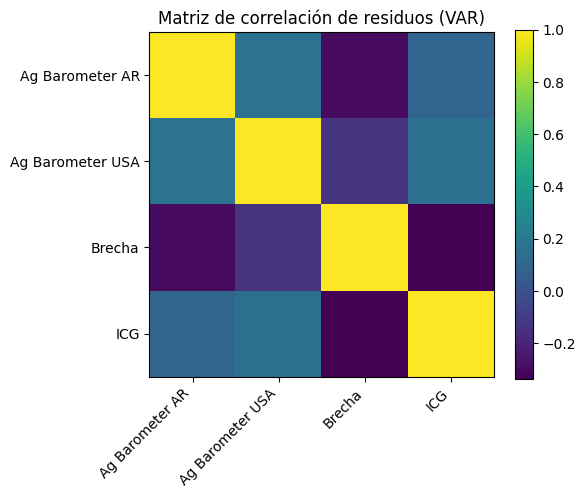

In [108]:
print("\n=== Durbin-Watson por ecuación (residuos) ===")
dw = durbin_watson(var_result.resid)
for col, val in zip(vars_var, dw):
    print(f"DW {col}: {val:.2f}")

print("\n=== Correlación de residuos ===")
resid_corr = pd.DataFrame(var_result.resid, columns=vars_var).corr()
print(resid_corr)

plt.figure(figsize=(6, 5))
plt.imshow(resid_corr.values)
plt.xticks(range(len(vars_var)), vars_var, rotation=45, ha='right')
plt.yticks(range(len(vars_var)), vars_var)
plt.title("Matriz de correlación de residuos (VAR)")
plt.colorbar()
plt.tight_layout()
plt.show()

Antes de aplicar los tests de causalidad de Granger, se evaluó la adecuación del modelo mediante diagnósticos de residuos. Los estadísticos de Durbin–Watson no evidencian autocorrelación serial, lo que valida el uso de los tests de causalidad sobre el VAR estimado.

#### 8. Causalidad de Granger (matriz de p-valores)


=== Matriz Granger (p-valores mínimos, maxlag=2) ===
                    Ag Barometer AR_x  Ag Barometer USA_x  Brecha_x     ICG_x
Ag Barometer AR_y                 NaN            0.006127  0.777479  0.071418
Ag Barometer USA_y           0.264117                 NaN  0.742518  0.163906
Brecha_y                     0.306435            0.275490       NaN  0.003951
ICG_y                        0.674449            0.259380  0.145168       NaN


c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
 

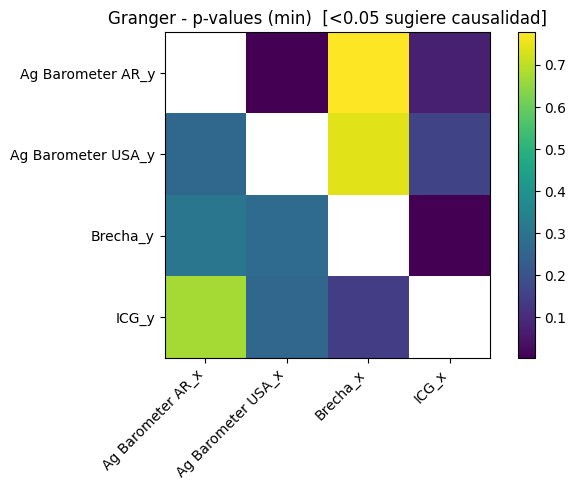


=== Tests puntuales de causalidad (VAR) ===
Granger causality F-test. H_0: Ag Barometer USA does not Granger-cause Ag Barometer AR. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         4.039          3.918   0.047 (1, 124)
----------------------------------------------
Granger causality F-test. H_0: ICG does not Granger-cause Brecha. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         7.118          3.918   0.009 (1, 124)
----------------------------------------------
Granger causality F-test. H_0: Brecha does not Granger-cause Ag Barometer AR. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.8249          3.918   0.366 (1, 124)
----------------------------------------------


In [109]:
def grangers_causation_matrix(data, variables, maxlag=2, test='ssr_chi2test'):
    """
    Matriz de p-valores mínimos (entre 1..maxlag) para Granger:
    filas = Y (afectada), columnas = X (causante)
    H0: X NO causa a Y (Granger)
    """
    df = pd.DataFrame(np.nan, index=variables, columns=variables)
    for y in variables:
        for x in variables:
            if y == x:
                continue
            test_result = grangercausalitytests(data[[y, x]], maxlag=maxlag, verbose=False)
            pvals = [test_result[i][0][test][1] for i in range(1, maxlag + 1)]
            df.loc[y, x] = np.min(pvals)

    df.columns = [f"{c}_x" for c in df.columns]
    df.index = [f"{r}_y" for r in df.index]
    return df

print("\n=== Matriz Granger (p-valores mínimos, maxlag=2) ===")
granger_mat = grangers_causation_matrix(train, vars_var, maxlag=2, test='ssr_chi2test')
print(granger_mat)

plt.figure(figsize=(7, 5))
plt.imshow(granger_mat.values)
plt.xticks(range(len(granger_mat.columns)), granger_mat.columns, rotation=45, ha='right')
plt.yticks(range(len(granger_mat.index)), granger_mat.index)
plt.title("Granger - p-values (min)  [<0.05 sugiere causalidad]")
plt.colorbar()
plt.tight_layout()
plt.show()

print("\n=== Tests puntuales de causalidad (VAR) ===")
print(var_result.test_causality(caused='Ag Barometer AR', causing=['Ag Barometer USA'], kind='f').summary())
print(var_result.test_causality(caused='Brecha', causing=['ICG'], kind='f').summary())
print(var_result.test_causality(caused='Ag Barometer AR', causing=['Brecha'], kind='f').summary())

El test de causalidad de Granger (con maxlag = 2) muestra que el Ag Barometer USA tiene capacidad predictiva sobre el Ag Barometer Argentina (p = 0.001), lo que sugiere que la evolución del indicador estadounidense ayuda a anticipar cambios en el indicador argentino. Además, se observa evidencia de causalidad de Granger desde el ICG hacia la brecha cambiaria (p = 0.004), indicando que las variaciones en el nivel de confianza general permiten predecir movimientos posteriores en la brecha. Para el resto de las combinaciones analizadas no se rechaza la hipótesis nula, por lo que no se encuentra evidencia de relaciones predictivas significativas entre las variables.

#### 9. IRF (impulso-respuesta)


=== IRF generales ===


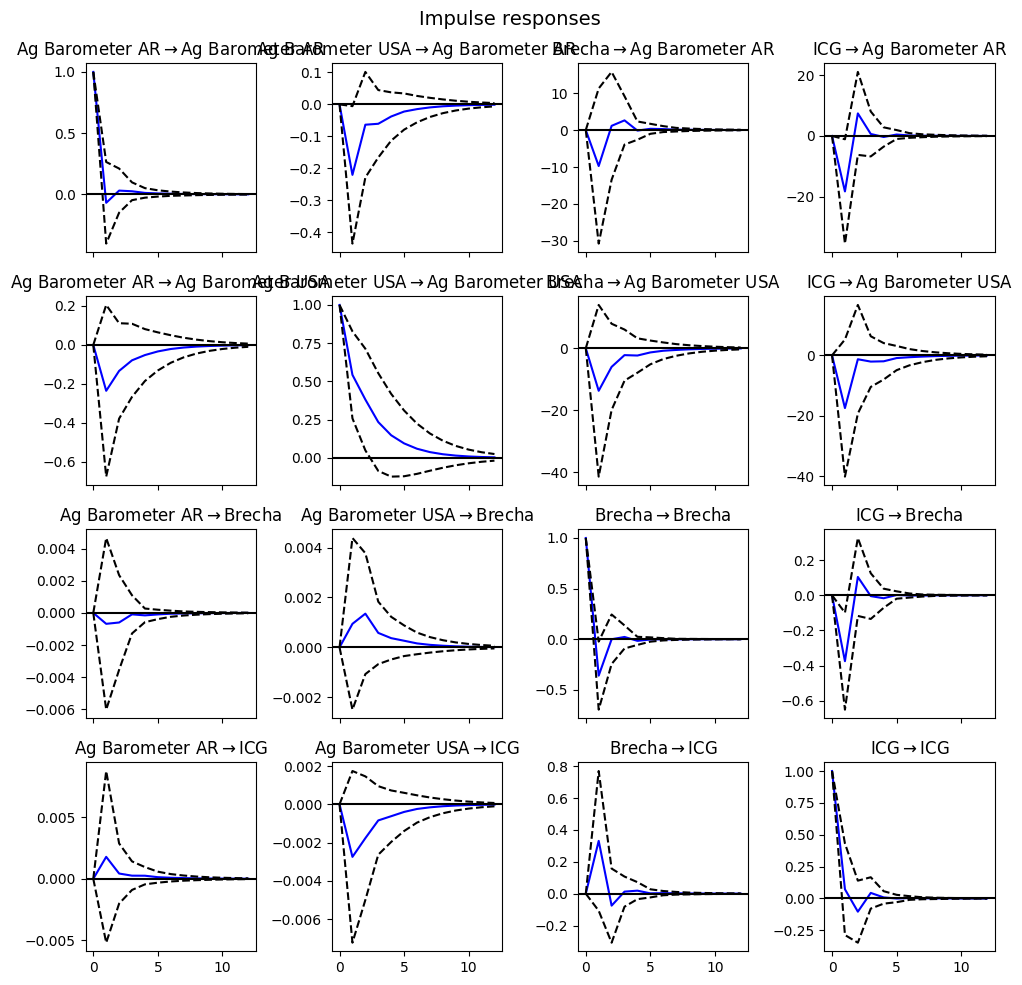

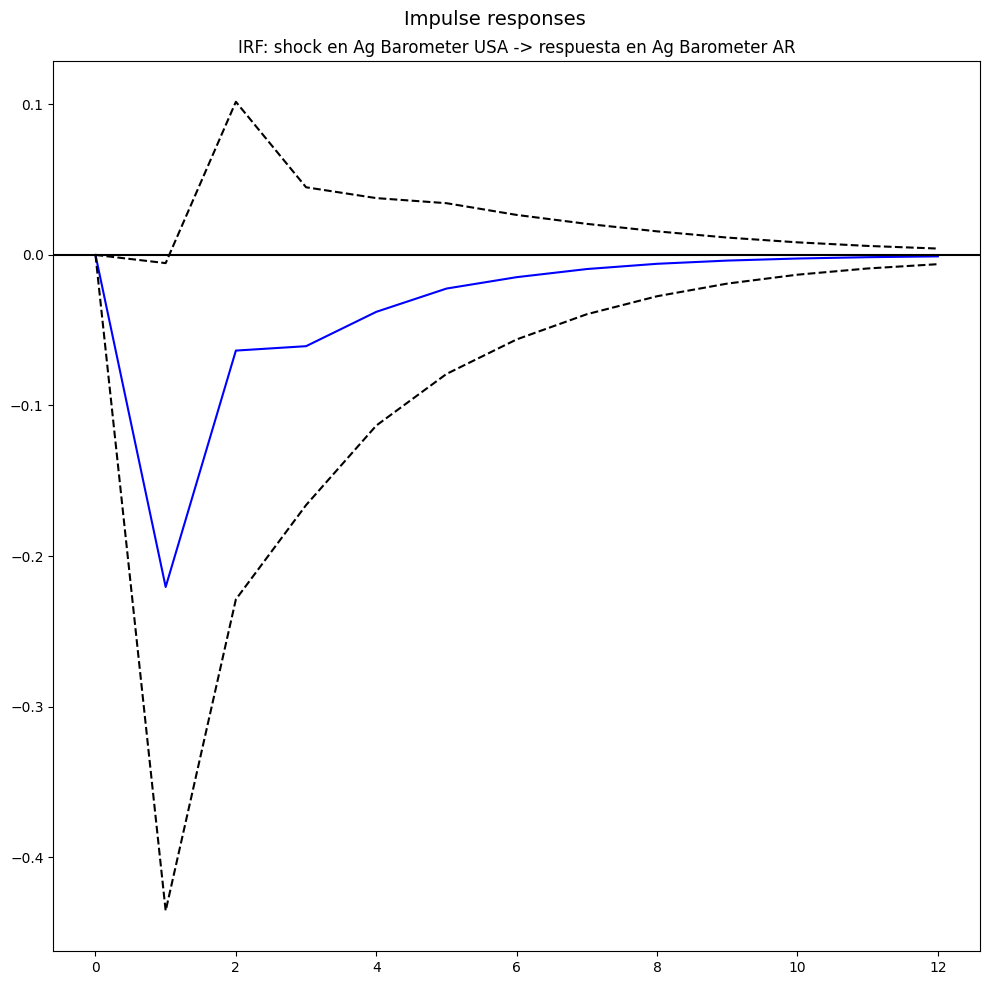

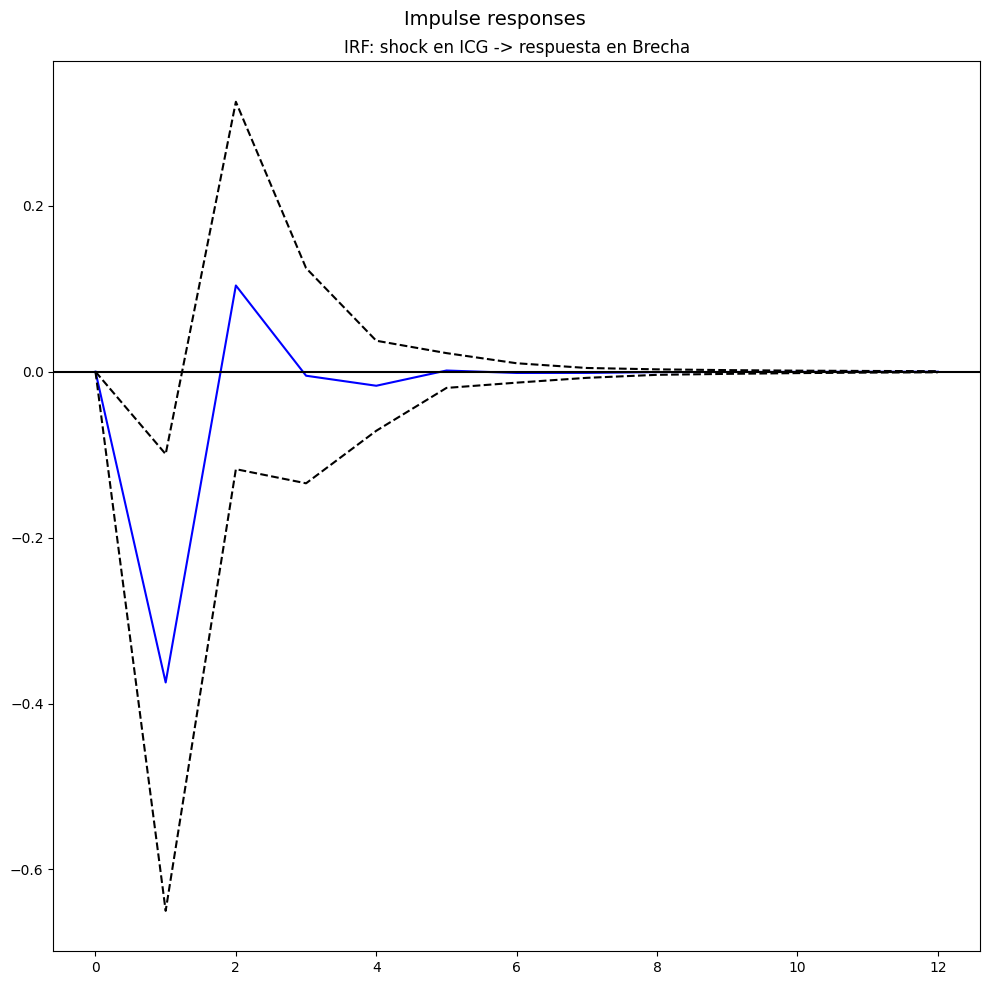

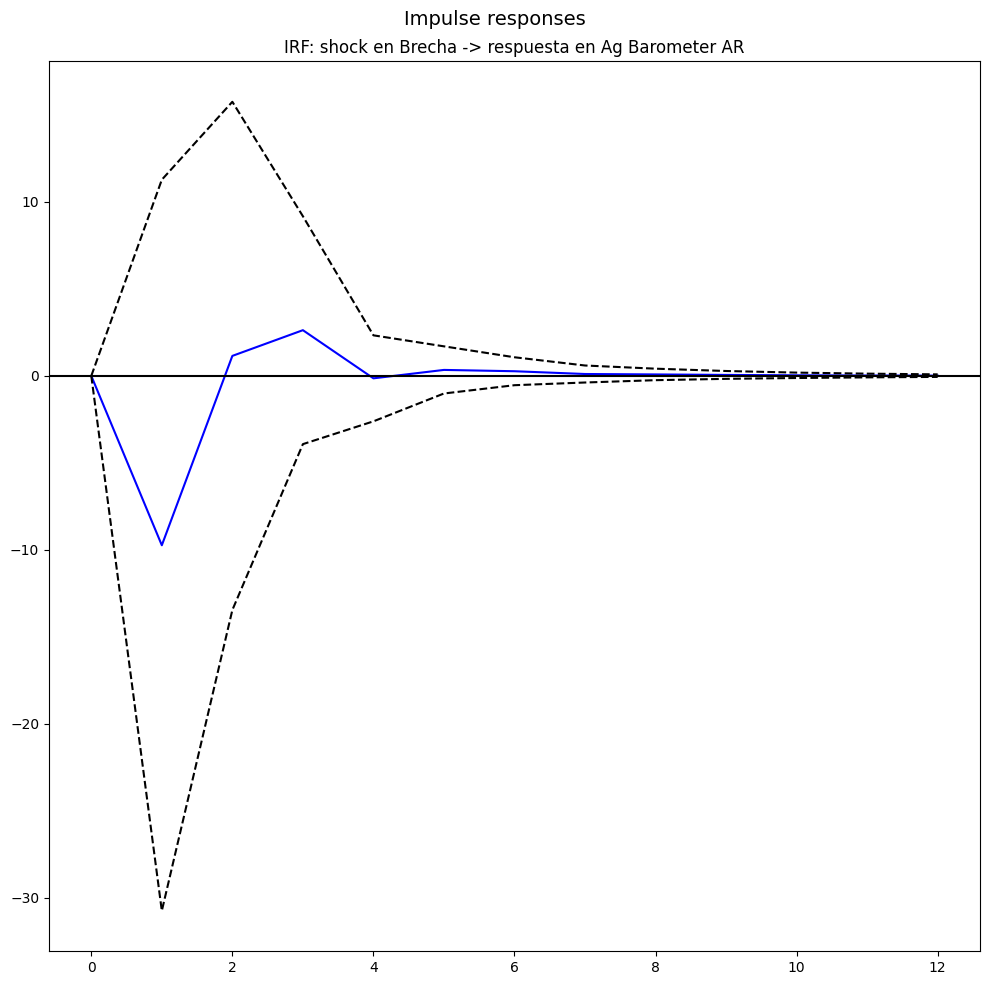

In [110]:
irf = var_result.irf(12)  # 12 bimestres ~ 2 años

print("\n=== IRF generales ===")
irf.plot()
plt.tight_layout()
plt.show()

for response, impulse in [
    ('Ag Barometer AR', 'Ag Barometer USA'),
    ('Brecha', 'ICG'),
    ('Ag Barometer AR', 'Brecha'),
]:
    irf.plot(response=response, impulse=impulse)
    plt.title(f"IRF: shock en {impulse} -> respuesta en {response}")
    plt.tight_layout()
    plt.show()

Las funciones impulso–respuesta muestran que los shocks tienen efectos mayormente transitorios. En particular, un shock en el Ag Barometer USA genera una respuesta negativa de corto plazo en el Ag Barometer Argentina, que se disipa luego de algunos bimestres, lo que refuerza la evidencia de una relación dinámica entre ambos indicadores. Asimismo, un shock positivo en el ICG produce una reducción transitoria en la brecha cambiaria, consistente con los resultados del test de Granger. En cambio, no se observan respuestas significativas del Ag Barometer Argentina frente a shocks en la brecha. En general, los IRF confirman que las interacciones entre las variables existen pero son de corto plazo y no persistentes.

#### 10. FEVD (descomposición de varianza)


=== FEVD plot ===


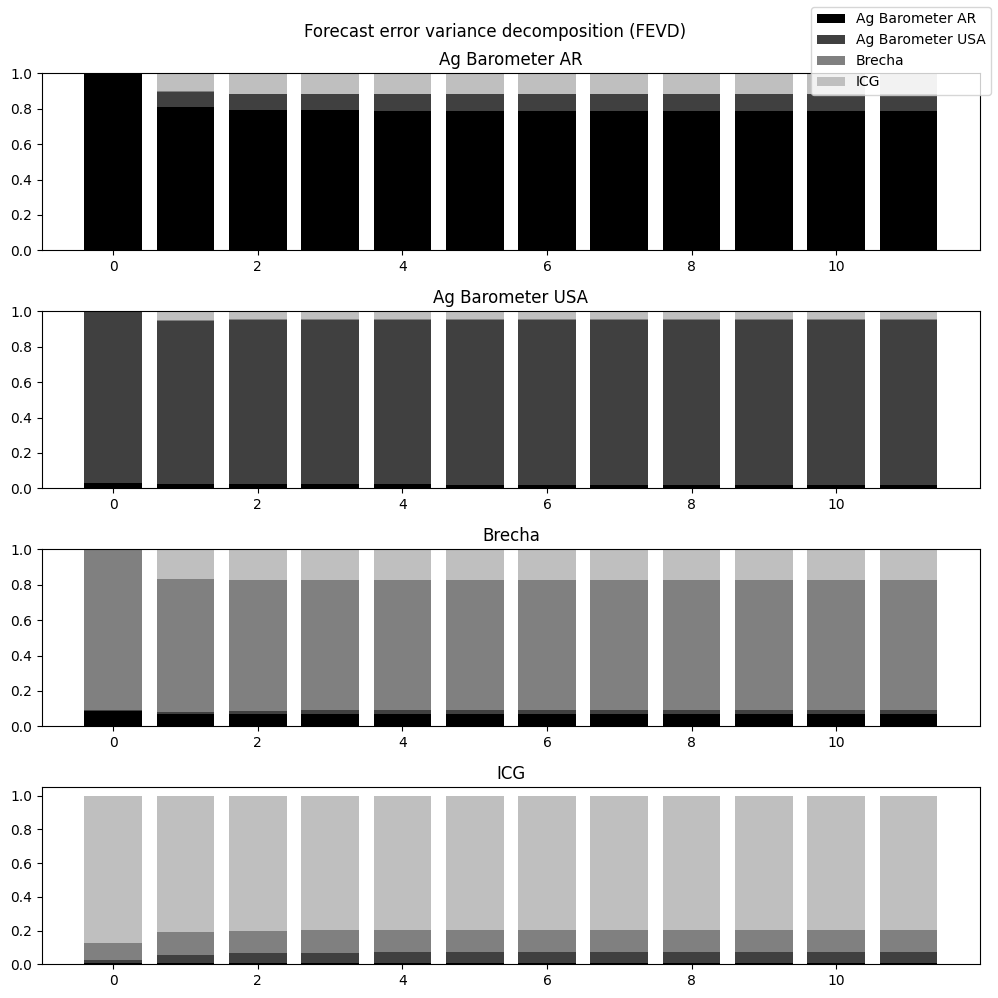


=== FEVD tabla: Ag Barometer AR ===
     Ag Barometer AR  Ag Barometer USA    Brecha      ICG
h=1         1.000000          0.000000  0.000000  0.00000
h=2         0.028826          0.971174  0.000000  0.00000
h=3         0.088196          0.006477  0.905327  0.00000
h=4         0.009302          0.017981  0.098187  0.87453


In [111]:
fevd = var_result.fevd(12)

print("\n=== FEVD plot ===")
fevd.plot()
plt.tight_layout()
plt.show()

# Tabla FEVD para Ag Barometer AR (opcional)
idx = vars_var.index('Ag Barometer AR')
fevd_table = pd.DataFrame(fevd.decomp[:, idx, :], columns=vars_var)
fevd_table.index = [f"h={i+1}" for i in range(fevd_table.shape[0])]
print("\n=== FEVD tabla: Ag Barometer AR ===")
print(fevd_table)

La descomposición de la varianza del error de pronóstico muestra que, en la mayoría de los casos, las variables están explicadas principalmente por sus propios shocks. En el Ag Barometer Argentina, la mayor parte de la variabilidad se debe a su propia dinámica, aunque con el paso del tiempo el Ag Barometer USA empieza a ganar importancia, lo que sugiere que el contexto internacional tiene un rol relevante en su evolución. En el caso de la brecha cambiaria, además de los shocks propios, el ICG explica una parte no menor de su variabilidad, lo que es consistente con los resultados obtenidos en el test de Granger y en las funciones impulso–respuesta. Por otro lado, el Ag Barometer USA se comporta de manera más independiente dentro del sistema, ya que su varianza está explicada casi en su totalidad por shocks propios.

#### 11. Forecast 

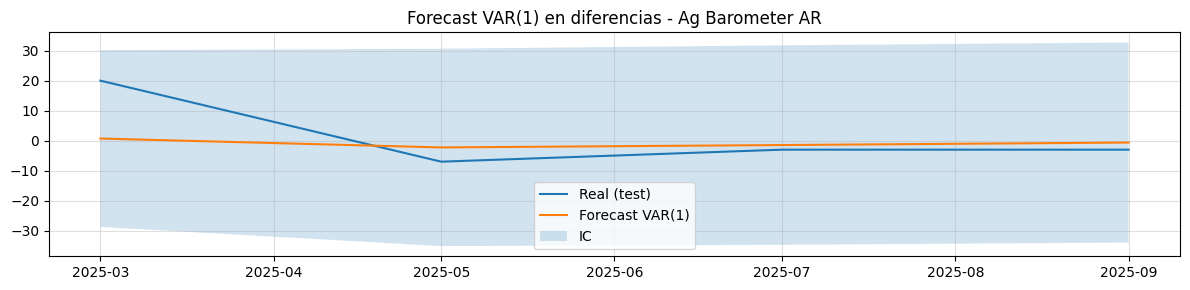

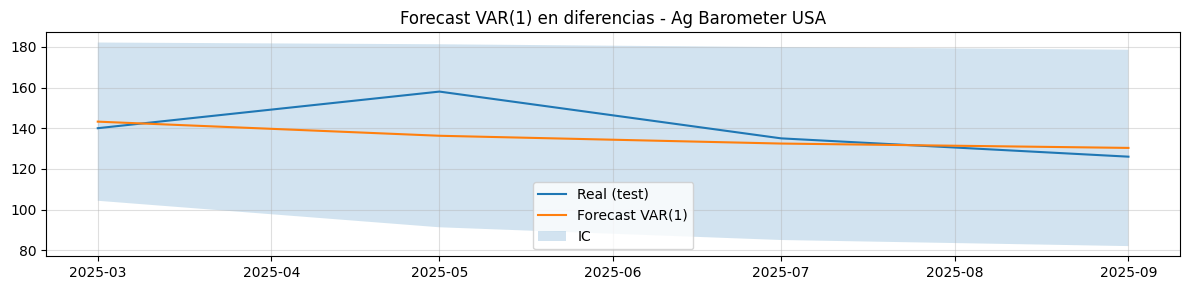

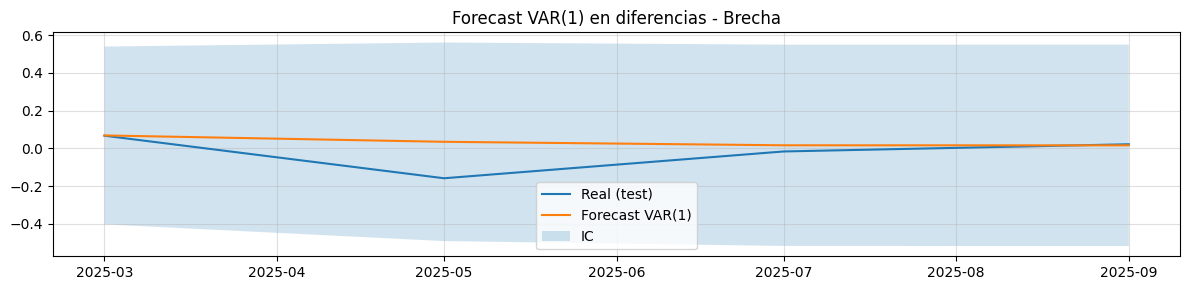

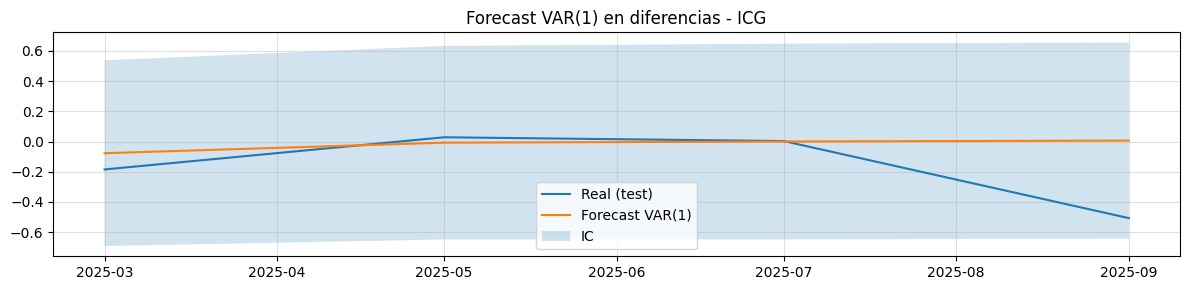

In [112]:
steps = len(test)
last_obs = train.values[-var_result.k_ar:]

forecast, lower, upper = var_result.forecast_interval(last_obs, steps=steps)

forecast_df = pd.DataFrame(forecast, index=test.index, columns=vars_var)
lower_df    = pd.DataFrame(lower,   index=test.index, columns=vars_var)
upper_df    = pd.DataFrame(upper,   index=test.index, columns=vars_var)

for col in vars_var:
    plt.figure(figsize=(12, 3))
    plt.plot(test.index, test[col], label="Real (test)")
    plt.plot(forecast_df.index, forecast_df[col], label="Forecast VAR(1)")
    plt.fill_between(forecast_df.index, lower_df[col], upper_df[col], alpha=0.2, label="IC")
    plt.title(f"Forecast VAR(1) en diferencias - {col}")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

Como el VAR se estimó sobre series diferenciadas, el pronóstico se interpreta como predicción de cambios (Δ) y no de niveles. En el caso del Ag Barometer AR, el modelo tiende a proyectar variaciones cercanas a cero, mientras que los valores observados en el test muestran un movimiento más brusco al inicio. Además, los intervalos de confianza resultan amplios, lo cual es esperable dado el tamaño reducido de la muestra y la cantidad de variables del sistema. Por eso, esta parte se toma más como una validación del enfoque que como una predicción precisa.